In [40]:
import os
import time
import requests
# from sentence_transformers import SentenceTransformer
from langchain.embeddings import OpenAIEmbeddings
from dotenv import load_dotenv
from pymongo import MongoClient
from langchain_experimental.text_splitter import SemanticChunker
import requests
from datetime import datetime

In [6]:
symbol = "AAPL"
pages = [1,2,3,4,5,6,7,8,9,10]
limits = 100
fmp_api_key = "b6adf265209f12e18fd61e2f403585c3"

In [7]:
fmp_articles = []
stock_news = []

In [8]:
for page in pages:
    print(f"Fetching {symbol} page:{page}...")
    url = f"https://financialmodelingprep.com/stable/fmp-articles?limit={limits}&page={page}&apikey={fmp_api_key}"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        page_data = response.json()
        if page_data:
            fmp_articles.extend(page_data)  # Append results
        else:
            print(f"No data on page {page}")
    else:
        print(f"Error {response.status_code} on page {page}")

Fetching AAPL page:1...
Fetching AAPL page:2...
Fetching AAPL page:3...
Fetching AAPL page:4...
Fetching AAPL page:5...
Fetching AAPL page:6...
Fetching AAPL page:7...
Fetching AAPL page:8...
Fetching AAPL page:9...
Fetching AAPL page:10...


In [10]:
for page in pages:
    print(f"Fetching {symbol} page:{page}...")
    url = f"https://financialmodelingprep.com/stable/news/stock-latest?limit={limits}&page={page}&apikey={fmp_api_key}"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        page_data = response.json()
        if page_data:
            stock_news.extend(page_data)  # Append results
        else:
            print(f"No data on page {page}")
    else:
        print(f"Error {response.status_code} on page {page}")

Fetching AAPL page:1...
Fetching AAPL page:2...
Fetching AAPL page:3...
Fetching AAPL page:4...
Fetching AAPL page:5...
Fetching AAPL page:6...
Fetching AAPL page:7...
Fetching AAPL page:8...
Fetching AAPL page:9...
Fetching AAPL page:10...


In [27]:
# url = f"https://financialmodelingprep.com/stable/news/stock-latest?apikey={fmp_api_key}"
# response = requests.get(url)
# stock_news_list  = response.json()

# url = f"https://financialmodelingprep.com/stable/fmp-articles?apikey={fmp_api_key}"
# response = requests.get(url)
# fmp_articles_list   = response.json()



In [11]:
def extract_tickers(article):
    if "symbol" in article:
        return [article["symbol"]]
    elif "tickers" in article:
        return [t.split(":")[1] for t in article["tickers"].split(",") if "AAPL" in t]
    else:
        return []

# --- Filter AAPL articles from both lists ---
aapl_articles = []

for article in stock_news:
    if "AAPL" in extract_tickers(article):
        aapl_articles.append(article)

for article in fmp_articles:
    if "AAPL" in extract_tickers(article):
        aapl_articles.append(article)

print(f"Total AAPL articles found: {len(aapl_articles)}")

Total AAPL articles found: 39


In [14]:
aapl_articles

[{'symbol': 'AAPL',
  'publishedDate': '2025-04-22 09:00:00',
  'publisher': 'Business Wire',
  'title': "Children's Hospital Los Angeles Launches First-of-its-Kind Sleep App and Sleep Registry for Children Using Apple Watch",
  'image': 'https://images.financialmodelingprep.com/news/childrens-hospital-los-angeles-launches-firstofitskind-sleep-app-and-20250422.jpg',
  'site': 'businesswire.com',
  'text': "LOS ANGELES--(BUSINESS WIRE)--Children's Hospital Los Angeles (CHLA) is launching the first sleep registry in the country for children using Apple Watch as well as a new data collection app called WISE-HARE, or Wearable Intelligent Sensor Enhancement Home Apnea Risk Evaluation. The app was developed to gather streams of high-fidelity data for future research, such as training machine learning algorithms from Apple Watch data to detect sleep disorders and provide crucial information to clinician.",
  'url': 'https://www.businesswire.com/news/home/20250422603069/en/Children%E2%80%99s-H

In [15]:
def normalize_article(article):
    return {
        "symbol": article.get("symbol", article.get("tickers", "").replace("STOCK:", "").replace("NASDAQ:", "").strip()),
        "date": article.get("publishedDate", article.get("date")),
        "publisher": article.get("publisher", article.get("author", "")),
        "title": article.get("title"),
        "site": article.get("site"),
        "text": article.get("text", article.get("content")),
        "url": article.get("url", article.get("link"))
    }

# Assuming `raw_articles` contains your entire list
normalized_articles = [normalize_article(article) for article in aapl_articles]

# Optional: sort by date (newest first)
normalized_articles = sorted(normalized_articles, key=lambda x: x['date'], reverse=True)


In [17]:
normalized_articles

[{'symbol': 'AAPL',
  'date': '2025-04-22 09:00:00',
  'publisher': 'Business Wire',
  'title': "Children's Hospital Los Angeles Launches First-of-its-Kind Sleep App and Sleep Registry for Children Using Apple Watch",
  'site': 'businesswire.com',
  'text': "LOS ANGELES--(BUSINESS WIRE)--Children's Hospital Los Angeles (CHLA) is launching the first sleep registry in the country for children using Apple Watch as well as a new data collection app called WISE-HARE, or Wearable Intelligent Sensor Enhancement Home Apnea Risk Evaluation. The app was developed to gather streams of high-fidelity data for future research, such as training machine learning algorithms from Apple Watch data to detect sleep disorders and provide crucial information to clinician.",
  'url': 'https://www.businesswire.com/news/home/20250422603069/en/Children%E2%80%99s-Hospital-Los-Angeles-Launches-First-of-its-Kind-Sleep-App-and-Sleep-Registry-for-Children-Using-Apple-Watch/'},
 {'symbol': 'AAPL',
  'date': '2025-04-2

In [ ]:
normalized_articles

In [34]:
from pymongo import MongoClient
from langchain.embeddings import OpenAIEmbeddings
import os

# MongoDB setup
mongo_client = MongoClient(os.getenv("MONGO_URI"))
db = mongo_client["qualitative"]
collection = db["news"]

# Embedding model (OpenAI)
oaiembeds = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

def process_and_insert_news(file):
    text = file.get("text", "")
    if not text:
        print("❌ No text found in file.")
        return

    # Generate embedding for the full news text
    embedding = oaiembeds.embed_query(text)

    # Prepare document
    doc = {
        "content": text,
        "embedding": embedding,
        "ticker": file.get("symbol", ""),
        "url": file.get("url", file.get("link", "")),
        "title": file.get("title", ""),
        "site": file.get("site", ""),
        "publisher": file.get("publisher", file.get("author", "")),
        "date": datetime.fromisoformat(file.get("date", file.get("publishedDate", ""))),
    }

    # Insert into MongoDB
    collection.insert_one(doc)
    print(f"✅ Inserted news article with title: {file.get('title', '')}")


In [35]:
normalized_articles

[{'symbol': 'AAPL',
  'date': '2025-04-22 09:00:00',
  'publisher': 'Business Wire',
  'title': "Children's Hospital Los Angeles Launches First-of-its-Kind Sleep App and Sleep Registry for Children Using Apple Watch",
  'site': 'businesswire.com',
  'text': "LOS ANGELES--(BUSINESS WIRE)--Children's Hospital Los Angeles (CHLA) is launching the first sleep registry in the country for children using Apple Watch as well as a new data collection app called WISE-HARE, or Wearable Intelligent Sensor Enhancement Home Apnea Risk Evaluation. The app was developed to gather streams of high-fidelity data for future research, such as training machine learning algorithms from Apple Watch data to detect sleep disorders and provide crucial information to clinician.",
  'url': 'https://www.businesswire.com/news/home/20250422603069/en/Children%E2%80%99s-Hospital-Los-Angeles-Launches-First-of-its-Kind-Sleep-App-and-Sleep-Registry-for-Children-Using-Apple-Watch/'},
 {'symbol': 'AAPL',
  'date': '2025-04-2

In [36]:
def remove_duplicate_articles(articles):
    seen = set()
    unique_articles = []
    for article in articles:
        url = article.get("url")
        if url and url not in seen:
            seen.add(url)
            unique_articles.append(article)
    return unique_articles


In [37]:
deduplicated_articles = remove_duplicate_articles(normalized_articles)

In [38]:
deduplicated_articles

[{'symbol': 'AAPL',
  'date': '2025-04-22 09:00:00',
  'publisher': 'Business Wire',
  'title': "Children's Hospital Los Angeles Launches First-of-its-Kind Sleep App and Sleep Registry for Children Using Apple Watch",
  'site': 'businesswire.com',
  'text': "LOS ANGELES--(BUSINESS WIRE)--Children's Hospital Los Angeles (CHLA) is launching the first sleep registry in the country for children using Apple Watch as well as a new data collection app called WISE-HARE, or Wearable Intelligent Sensor Enhancement Home Apnea Risk Evaluation. The app was developed to gather streams of high-fidelity data for future research, such as training machine learning algorithms from Apple Watch data to detect sleep disorders and provide crucial information to clinician.",
  'url': 'https://www.businesswire.com/news/home/20250422603069/en/Children%E2%80%99s-Hospital-Los-Angeles-Launches-First-of-its-Kind-Sleep-App-and-Sleep-Registry-for-Children-Using-Apple-Watch/'},
 {'symbol': 'AAPL',
  'date': '2025-04-2

In [41]:
for i in deduplicated_articles:
    try:
        process_and_insert_news(i)
    except Exception as e:
        print(f"Error processing file {i.get("date", "")}: {e}")
            

✅ Inserted news article with title: Children's Hospital Los Angeles Launches First-of-its-Kind Sleep App and Sleep Registry for Children Using Apple Watch
✅ Inserted news article with title: Boost Mobile Introduces iPad and Apple Watch to Its Device Lineup
✅ Inserted news article with title: 22% of Warren Buffett-Led Berkshire Hathaway's $265 Billion Portfolio Is Invested in Only 1 Stock
✅ Inserted news article with title: Warren Buffett Timed His Apple Stock Sale to Perfection. What's Next?
✅ Inserted news article with title: Ragnarok M: Classic (Chinese title: RO仙境傳說：守護永恆的愛 Classic) Ranked First in Taiwan, Second in Macau and Fourth in Hong Kong in Top Grossing of Apple App Store
✅ Inserted news article with title: Should You Buy Apple Stock Before May 1?
✅ Inserted news article with title: Despite Cutting Apple's Price Target, Wedbush's Dan Ives Remains Bullish on the Stock for the Long Term. Should You?
✅ Inserted news article with title: After Trump Spares Apple, Other Businesses 

In [47]:
result = insert_article({
        "url": "https://seekingalpha.com/article/4776258-selling-america-buying-europe-my-picks",
        "title": "Selling America, Buying Europe - My Picks",
        "date": "2025-04-20 09:15:00",
        "source": "seekingalpha.com",
        "image": "https://images.financialmodelingprep.com/news/selling-america-buying-europe-my-picks-20250420.jpg",
        "content": "After years of strong returns, amidst the tariff-induced uncertainty, I am rotating towards European-based equities. US economy is facing mounting pressures, via weakening consumer demand, reduced CAPEX spending, inflation, and rising recession odds. European equities are relatively cheap, and despite structural issues, pockets of opportunities exist in high-growth areas and via re-arming Europe initiative.",
      })

In [48]:
result

{'url': 'https://seekingalpha.com/article/4776258-selling-america-buying-europe-my-picks',
 'title': 'Selling America, Buying Europe - My Picks',
 'date': '2025-04-20 09:15:00',
 'source': 'seekingalpha.com',
 'image': 'https://images.financialmodelingprep.com/news/selling-america-buying-europe-my-picks-20250420.jpg',
 'content': 'After years of strong returns, amidst the tariff-induced uncertainty, I am rotating towards European-based equities. US economy is facing mounting pressures, via weakening consumer demand, reduced CAPEX spending, inflation, and rising recession odds. European equities are relatively cheap, and despite structural issues, pockets of opportunities exist in high-growth areas and via re-arming Europe initiative.',
 'cluster_name': 'European Equity Investment Shift'}

In [33]:
aapl_articles_cleaned=[{'title': 'Investors Slash Stock Exposure Amid Uncertainty, Yet New Money Flows In',
  'date': '2025-04-15 06:25:24',
  'content': '<p>Investors have cut their equity exposure to levels not seen in years, as fears over economic growth mix with cautious optimism for policy support. According to Deutsche Bank, overall positioning in stocks has fallen well below normal, with both computer-driven funds and traditional investors scaling back amid persistent uncertainty.</p>\r\n<hr />\r\n<h3>Key Points on Investor Positioning</h3>\r\n<ul>\r\n<li>\r\n<p><strong>Systematic Strategies Pull Back</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Automated, rules-based funds&mdash;commonly known as systematic or volatility control funds&mdash;have slashed their stock holdings to near the lowest levels recorded since the COVID-19 shock in March 2020.</p>\r\n</li>\r\n<li>\r\n<p>These funds may resume buying if small market dips (less than 3%) occur and volatility continues to ease.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Traditional Investors Remain Cautious</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Discretionary fund managers have also maintained low but steady exposure, waiting for clearer signs from economic data.</p>\r\n</li>\r\n<li>\r\n<p>Their restrained positioning reflects an anticipation of a slowdown in GDP growth and company earnings despite a recent slight uptick due to a pause in trade tensions.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Mixed Regional Flows</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>While U.S. stock funds recorded significant inflows&mdash;nearly $31 billion, including into leveraged funds betting on rising markets&mdash;European and Japanese funds experienced notable outflows.</p>\r\n</li>\r\n<li>\r\n<p>China, however, saw strong inflows of $26 billion, the highest in six months, supporting local equity markets.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Overnight Trading Concerns</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Notably, much of the recent decline in the S&amp;P 500 has occurred during overnight trading, marking a shift from the historically stronger performance seen during regular market hours.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n</ul>\r\n<hr />\r\n<h3>Market Flows and Future Outlook</h3>\r\n<ul>\r\n<li>\r\n<p><strong>Investor Caution Remains</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Despite recent selloffs, new money continues to flow into equities, indicating that some investors are willing to step in amid the volatility.</p>\r\n</li>\r\n<li>\r\n<p>Deutsche Bank and other market analysts warn that uncertainty over U.S. macro policy and the possibility of a recession weigh on sentiment, even as some tariff-related risks are easing.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Policy and Earnings in Focus</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>With more corporate earnings reports on the horizon, particularly in key sectors like banking and technology, market watchers await further economic signals.</p>\r\n</li>\r\n<li>\r\n<p>Investors are keeping an eye on potential policy changes that could provide a clearer path for a sustained market recovery.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n</ul>\r\n<hr />\r\n<h3>Track Real-Time Market Trends</h3>\r\n<p>For those interested in monitoring trading activity and understanding which stocks are driving market momentum, the<br />🔗 <a href="https://site.financialmodelingprep.com/developer/docs#market-biggest-gainers-market-overview">Market Biggest Gainers Market Overview API</a> from Financial Modeling Prep offers real-time insight into the day&rsquo;s leading market performers.</p>',
  'image': 'https://portal.financialmodelingprep.com//coverphotos/67fe33db864b6d1a4db5463e.png',
  'url': 'https://financialmodelingprep.com/market-news/investors-slash-stock-exposure-amid-uncertainty-yet-new-money-flows-in',
  'source': 'FinancialModelingPrep.com',
  'cluster_name': 'Chip Equipment Tariff Challenges'},
 {'url': 'https://www.zacks.com/stock/news/2451495/ibn-s-q4-earnings-increase-y-y-as-nii-fee-income-rise-provisions-up?cid=CS-STOCKNEWSAPI-FT-analyst_blog|earnings_article-2451495',
  'title': "IBN's Q4 Earnings Increase Y/Y as NII & Fee Income Rise, Provisions Up",
  'date': '2025-04-21 07:35:29',
  'source': 'zacks.com',
  'image': 'https://images.financialmodelingprep.com/news/ibns-q4-earnings-increase-yy-as-nii-fee-income-20250421.jpg',
  'content': "A rise in revenues and loans and deposit balances drives ICICI Bank's Q4 earnings, while higher expenses and provisions act as spoilsports.",
  'cluster_id': 59},
 {'url': 'https://seekingalpha.com/article/4776258-selling-america-buying-europe-my-picks',
 'title': 'Selling America, Buying Europe - My Picks',
 'date': '2025-04-20 09:15:00',
 'source': 'seekingalpha.com',
 'image': 'https://images.financialmodelingprep.com/news/selling-america-buying-europe-my-picks-20250420.jpg',
 'content': 'After years of strong returns, amidst the tariff-induced uncertainty, I am rotating towards European-based equities. US economy is facing mounting pressures, via weakening consumer demand, reduced CAPEX spending, inflation, and rising recession odds. European equities are relatively cheap, and despite structural issues, pockets of opportunities exist in high-growth areas and via re-arming Europe initiative.',
 'cluster_name': 'European Equity Investment Shift'}]

['<p>Investors have cut their equity exposure to levels not seen in years, as fears over economic growth mix with cautious optimism for policy support. According to Deutsche Bank, overall positioning in stocks has fallen well below normal, with both computer-driven funds and traditional investors scaling back amid persistent uncertainty.</p>\r\n<hr />\r\n<h3>Key Points on Investor Positioning</h3>\r\n<ul>\r\n<li>\r\n<p><strong>Systematic Strategies Pull Back</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Automated, rules-based funds&mdash;commonly known as systematic or volatility control funds&mdash;have slashed their stock holdings to near the lowest levels recorded since the COVID-19 shock in March 2020.</p>\r\n</li>\r\n<li>\r\n<p>These funds may resume buying if small market dips (less than 3%) occur and volatility continues to ease.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Traditional Investors Remain Cautious</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Discretionary fund managers have a

c:\Users\hp\RAG_17-04-2025\venv\Lib\site-packages\kneed\knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
c:\Users\hp\RAG_17-04-2025\venv\Lib\site-packages\kneed\knee_locator.py:208: RuntimeWarning: Mean of empty slice.
  self.S * np.abs(np.diff(self.x_normalized).mean())
c:\Users\hp\RAG_17-04-2025\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


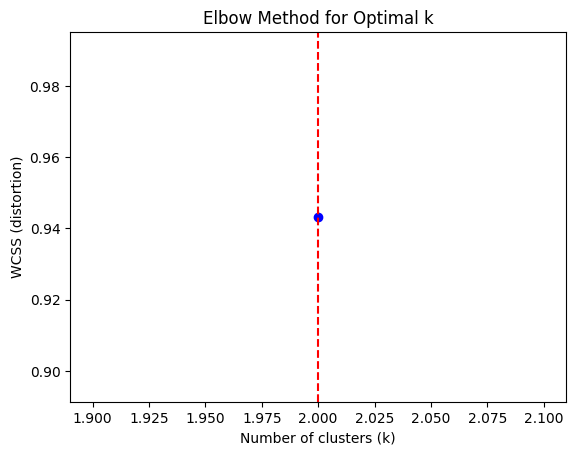

✅ Optimal number of clusters (k): 2

✅ Clusters updated and saved. Use `insert_article(article)` for new data.


In [34]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from collections import defaultdict
from kneed import KneeLocator
import json
import openai
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import os

# === CONFIG ===
openai.api_key = os.getenv("OPENAI_API_KEY")
SIM_THRESHOLD = 0.70
CLUSTER_FILE = "clusters.pkl"

# === STEP 1: Load existing clusters if available ===
if os.path.exists(CLUSTER_FILE):
    with open(CLUSTER_FILE, "rb") as f:
        existing_clusters = pickle.load(f)
else:
    existing_clusters = {}  # cluster_name -> {centroid, count, articles}

# === STEP 2: Preprocess new batch ===
texts = []
transcript_meta = []

for transcript in aapl_articles_cleaned:
    content = transcript.get("content") or transcript.get("text", "")
    if not content.strip():
        continue

    meta = {
        "url": transcript.get("url", ""),
        "title": transcript.get("title", ""),
        "date": transcript.get("date", ""),
        "source": transcript.get("source", ""),
        "image": transcript.get("image", ""),
        "content": content
    }

    texts.append(content)
    transcript_meta.append(meta)

# === STEP 3: TF-IDF Vectorization ===
print(texts)
vectorizer = TfidfVectorizer(max_features=1500, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(texts)

# === STEP 4: Elbow method for optimal k ===
distortions = []
K = range(2, min(11, len(texts)))
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    km.fit(tfidf_matrix)
    distortions.append(km.inertia_)
if not distortions:
    raise ValueError("No distortions computed. Ensure tfidf_matrix and texts are non-empty.")
kneedle = KneeLocator(K, distortions, curve="convex", direction="decreasing")
optimal_k = kneedle.knee or 2

plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (distortion)')
plt.title('Elbow Method for Optimal k')
plt.axvline(optimal_k, color='red', linestyle='--')
plt.show()

print(f"\u2705 Optimal number of clusters (k): {optimal_k}")

# === STEP 5: Apply KMeans Clustering ===
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
labels = kmeans.fit_predict(tfidf_matrix)

for meta, label in zip(transcript_meta, labels):
    meta["cluster_id"] = int(label)

# === STEP 6: Generate cluster name using GPT ===
def generate_cluster_name(titles, content_snippets):
    prompt = """
Suggest a short and meaningful category name (max 6 words) for the following cluster of news articles:

Titles:
- {}

Contents:
- {}
Respond ONLY with the category name.
""".format("\n- ".join(titles[:5]), "\n- ".join(content_snippets[:5]))

    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that assigns topic labels to financial news clusters."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )
    return response.choices[0].message.content.strip()

# === STEP 7: Build Clusters with Names ===
cluster_groups = defaultdict(list)
for m in transcript_meta:
    cluster_groups[m["cluster_id"]].append(m)

for cid, group in cluster_groups.items():
    titles = [g["title"] for g in group if g["title"]]
    contents = [g["content"][:300] for g in group]

    cluster_name = generate_cluster_name(titles, contents)
    cluster_vector = np.mean(vectorizer.transform([g["content"] for g in group]).toarray(), axis=0)

    existing_clusters[cluster_name] = {
        "centroid": cluster_vector,
        "count": len(group),
        "articles": group
    }

# === STEP 8: Save Clusters ===
with open(CLUSTER_FILE, "wb") as f:
    pickle.dump(existing_clusters, f)

# === STEP 9: Classify a New Article ===
def classify_new_article(content):
    new_vec = vectorizer.transform([content]).toarray()
    best_score = 0
    best_cluster = None

    for name, data in existing_clusters.items():
        score = cosine_similarity([data["centroid"]], new_vec)[0][0]
        if score > best_score:
            best_score = score
            best_cluster = name
    print(f"🔍 Best match: {best_cluster} (score={best_score:.2f})")
    if best_score >= SIM_THRESHOLD:
        return best_cluster
    return None

# === STEP 10: Insert Article ===
def insert_article(article):
    content = article["content"]
    url = article.get("url", "")

    for cluster_name, cluster_data in existing_clusters.items():
        for existing_article in cluster_data["articles"]:
            if existing_article["url"] == url:
                article["cluster_name"] = cluster_name
                return article  # Already exists

    matched_cluster = classify_new_article(content)

    if matched_cluster:
        existing_clusters[matched_cluster]["articles"].append(article)
        existing_clusters[matched_cluster]["count"] += 1
        all_contents = [a["content"] for a in existing_clusters[matched_cluster]["articles"]]
        existing_clusters[matched_cluster]["centroid"] = np.mean(vectorizer.transform(all_contents).toarray(), axis=0)
        article["cluster_name"] = matched_cluster
    else:
        cluster_name = generate_cluster_name([article["title"]], [content[:300]])
        vector = vectorizer.transform([content]).toarray()[0]
        existing_clusters[cluster_name] = {
            "centroid": vector,
            "count": 1,
            "articles": [article]
        }
        article["cluster_name"] = cluster_name

    with open(CLUSTER_FILE, "wb") as f:
        pickle.dump(existing_clusters, f)

    return article

# === Optional Output ===
print("\n\u2705 Clusters updated and saved. Use `insert_article(article)` for new data.")


In [35]:
existing_clusters

{'Equity Market Shifts and Strategies': {'centroid': array([0.01077762, 0.01077762, 0.01077762, 0.01077762, 0.01077762,
         0.01077762, 0.        , 0.01077762, 0.02155524, 0.08128976,
         0.01077762, 0.01077762, 0.01077762, 0.01077762, 0.08128976,
         0.08128976, 0.01077762, 0.01077762, 0.        , 0.01639331,
         0.01077762, 0.07001961, 0.01077762, 0.02155524, 0.02155524,
         0.01077762, 0.01077762, 0.08128976, 0.01077762, 0.02155524,
         0.01077762, 0.08128976, 0.01077762, 0.02155524, 0.01077762,
         0.01077762, 0.01077762, 0.01077762, 0.01077762, 0.08128976,
         0.02155524, 0.01077762, 0.01077762, 0.01077762, 0.01077762,
         0.01077762, 0.01077762, 0.01077762, 0.08128976, 0.        ,
         0.07821627, 0.02155524, 0.01077762, 0.01077762, 0.01077762,
         0.01077762, 0.01077762, 0.        , 0.01077762, 0.02458997,
         0.01077762, 0.01077762, 0.03233286, 0.08128976, 0.13184256,
         0.02155524, 0.08128976, 0.13184256, 0.08128

In [36]:
# process_new_article.py
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
import openai

# === CONFIG ===
CLUSTER_FILE = "clusters.pkl"
SIM_THRESHOLD = 0.70
openai.api_key = os.getenv("OPENAI_API_KEY")

# === Load clusters ===
with open(CLUSTER_FILE, "rb") as f:
    clusters = pickle.load(f)

# === Refit vectorizer on all articles ===
all_texts = []
for c in clusters.values():
    all_texts.extend([a["content"] for a in c["articles"]])

vectorizer = TfidfVectorizer(max_features=1500, stop_words="english")
vectorizer.fit(all_texts)

# === Classify + Insert Function ===
def classify_and_insert(article):
    content = article["content"]
    new_vec = vectorizer.transform([content]).toarray()
    
    best_score, best_cluster = 0, None
    for name, data in clusters.items():
        score = cosine_similarity([data["centroid"]], new_vec)[0][0]
        if score > best_score:
            best_score, best_cluster = score, name

    if best_score >= SIM_THRESHOLD:
        clusters[best_cluster]["articles"].append(article)
        clusters[best_cluster]["count"] += 1
        all_contents = [a["content"] for a in clusters[best_cluster]["articles"]]
        clusters[best_cluster]["centroid"] = np.mean(vectorizer.transform(all_contents).toarray(), axis=0)
        article["cluster_name"] = best_cluster
    else:
        # Generate new cluster
        prompt = f"""You are a helpful assistant. Your task is to assign a **short and reusable topic label** for a financial news article.

Title: {article['title']}
Content: {article['content'][:400]}

Respond with only a 2–5 word lowercase label, such as:
- "biotech conference"
- "gold mining earnings"
- "etf analysis"
- "credit card mergers"
- "healthcare partnerships"

Do not include dates, long company names, or excessive detail. Just respond with the topic label."""
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that assigns topic labels to financial news."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3
        )
        new_name = response.choices[0].message.content.strip()
        clusters[new_name] = {
            "centroid": new_vec[0],
            "count": 1,
            "articles": [article]
        }
        article["cluster_name"] = new_name

    with open(CLUSTER_FILE, "wb") as f:
        pickle.dump(clusters, f)

    return article


In [40]:
data

[{'symbol': 'IBN',
  'publishedDate': '2025-04-21 07:35:29',
  'publisher': 'Zacks Investment Research',
  'title': "IBN's Q4 Earnings Increase Y/Y as NII & Fee Income Rise, Provisions Up",
  'image': 'https://images.financialmodelingprep.com/news/ibns-q4-earnings-increase-yy-as-nii-fee-income-20250421.jpg',
  'site': 'zacks.com',
  'text': "A rise in revenues and loans and deposit balances drives ICICI Bank's Q4 earnings, while higher expenses and provisions act as spoilsports.",
  'url': 'https://www.zacks.com/stock/news/2451495/ibn-s-q4-earnings-increase-y-y-as-nii-fee-income-rise-provisions-up?cid=CS-STOCKNEWSAPI-FT-analyst_blog|earnings_article-2451495'},
 {'symbol': 'ECC',
  'publishedDate': '2025-04-21 07:35:00',
  'publisher': 'Seeking Alpha',
  'title': 'Dirt Cheap Preferred Stocks For Safer Income, +9% Yield',
  'image': 'https://images.financialmodelingprep.com/news/dirt-cheap-preferred-stocks-for-safer-income-9-yield-20250421.jpg',
  'site': 'seekingalpha.com',
  'text': 'F

In [44]:
aapl_articles_cleaned

[{'title': "IBN's Q4 Earnings Increase Y/Y as NII & Fee Income Rise, Provisions Up",
  'date': '2025-04-21 07:35:29',
  'source': 'zacks.com',
  'url': 'https://www.zacks.com/stock/news/2451495/ibn-s-q4-earnings-increase-y-y-as-nii-fee-income-rise-provisions-up?cid=CS-STOCKNEWSAPI-FT-analyst_blog|earnings_article-2451495',
  'content': "A rise in revenues and loans and deposit balances drives ICICI Bank's Q4 earnings, while higher expenses and provisions act as spoilsports.",
  'image': 'https://images.financialmodelingprep.com/news/ibns-q4-earnings-increase-yy-as-nii-fee-income-20250421.jpg'},
 {'title': 'Dirt Cheap Preferred Stocks For Safer Income, +9% Yield',
  'date': '2025-04-21 07:35:00',
  'source': 'seekingalpha.com',
  'url': 'https://seekingalpha.com/article/4776157-dirt-cheap-preferred-stocks-for-safer-income-plus-9-percent-yield',
  'content': 'Fearful markets present opportunities for income investors. Embrace the Income Method to cut through market noise, focusing on rel

In [45]:
for i in aapl_articles_cleaned:
    result = classify_and_insert(i)
    print(result["cluster_name"])

Bank Earnings and Financial Performance
"preferred stocks investing"
"tariff impact forecast"
antitrust ruling google
"share consolidation"
"securities fraud investigation"
"securities class action"
"share consolidation"
"securities class action"
"share consolidation"
"pharmaceutical investigation"
"executive appointment"
"pharmaceutical clinical trials"
"securities class action"
"securities class action"
"securities class action"
"securities fraud investigation"
"kenya digital exchange"
"retirement investment stocks"
"share consolidation"
"securities class action"
"lithium spin-out"
"e-commerce earnings"
"securities class action"
"ev market challenges"
"securities class action"
"securities fraud investigation"
"securities class action"
"pharmaceutical investigation"
"securities fraud investigation"
"securities fraud investigation"
"commodities expo participation"
"securities class action"
"securities class action"
"biotech investor conference"
"securities class action"
"post-quantum c

In [46]:
for c in clusters.values():
    print(c)
    # break

{'centroid': array([0.01437016, 0.01437016, 0.01437016, 0.01437016, 0.01437016,
       0.01437016, 0.        , 0.01437016, 0.02874032, 0.05419317,
       0.01437016, 0.01437016, 0.01437016, 0.01437016, 0.05419317,
       0.05419317, 0.01437016, 0.01437016, 0.        , 0.02185775,
       0.01437016, 0.05214418, 0.01437016, 0.02874032, 0.02874032,
       0.01437016, 0.01437016, 0.05419317, 0.01437016, 0.02874032,
       0.01437016, 0.05419317, 0.01437016, 0.02874032, 0.01437016,
       0.01437016, 0.01437016, 0.01437016, 0.01437016, 0.05419317,
       0.02874032, 0.01437016, 0.01437016, 0.01437016, 0.01437016,
       0.01437016, 0.01437016, 0.01437016, 0.05419317, 0.        ,
       0.06307305, 0.02874032, 0.01437016, 0.01437016, 0.01437016,
       0.01437016, 0.01437016, 0.        , 0.01437016, 0.03278663,
       0.01437016, 0.01437016, 0.04311047, 0.05419317, 0.09335948,
       0.02874032, 0.05419317, 0.09335948, 0.05419317, 0.        ,
       0.01437016, 0.02874032, 0.01437016, 0.0541

In [30]:
existing_clusters

{'Equity Market Shifts & Strategies': {'centroid': array([0.01077762, 0.01077762, 0.01077762, 0.01077762, 0.01077762,
         0.01077762, 0.        , 0.01077762, 0.02155524, 0.08128976,
         0.01077762, 0.01077762, 0.01077762, 0.01077762, 0.08128976,
         0.08128976, 0.01077762, 0.01077762, 0.        , 0.01639331,
         0.01077762, 0.07001961, 0.01077762, 0.02155524, 0.02155524,
         0.01077762, 0.01077762, 0.08128976, 0.01077762, 0.02155524,
         0.01077762, 0.08128976, 0.01077762, 0.02155524, 0.01077762,
         0.01077762, 0.01077762, 0.01077762, 0.01077762, 0.08128976,
         0.02155524, 0.01077762, 0.01077762, 0.01077762, 0.01077762,
         0.01077762, 0.01077762, 0.01077762, 0.08128976, 0.        ,
         0.07821627, 0.02155524, 0.01077762, 0.01077762, 0.01077762,
         0.01077762, 0.01077762, 0.        , 0.01077762, 0.02458997,
         0.01077762, 0.01077762, 0.03233286, 0.08128976, 0.13184256,
         0.02155524, 0.08128976, 0.13184256, 0.0812897

In [136]:
def reset_clusters():
    global existing_clusters
    existing_clusters = {}
    if os.path.exists(CLUSTER_FILE):
        os.remove(CLUSTER_FILE)


In [140]:
reset_clusters()

In [110]:
# existing_clusters

In [95]:
{
    "symbol": "HBT",
    "publishedDate": "2025-04-21 07:05:00",
    "publisher": "GlobeNewsWire",
    "title": "HBT Financial, Inc. Announces First Quarter 2025 Financial Results",
    "image": "https://images.financialmodelingprep.com/news/hbt-financial-inc-announces-first-quarter-2025-financial-results-20250421.jpg",
    "site": "globenewswire.com",
    "text": "First Quarter Highlights Net income of $19.1 million, or $0.60 per diluted share; return on average assets (“ROAA”) of 1.54%; return on average stockholders' equity (“ROAE”) of 13.95%; and return on average tangible common equity (“ROATCE”) (1)  of 16.20% Adjusted net income (1)  of $19.3 million; or $0.61 per diluted share; adjusted ROAA (1)  of 1.55%; adjusted ROAE (1)  of 14.08%; and adjusted ROATCE (1)  of 16.36% Asset quality remained exceptional with nonperforming assets to total assets of 0.11% and net charge-offs to average loans of 0.05%, on an annualized basis Net interest margin increased 16 basis points to 4.12% and net interest margin (tax-equivalent basis) (1) increased 15 basis point to 4.16% BLOOMINGTON, Ill., April 21, 2025 (GLOBE NEWSWIRE) -- HBT Financial, Inc. (NASDAQ: HBT) (the “Company” or “HBT Financial” or “HBT”), the holding company for Heartland Bank and Trust Company, today reported net income of $19.1 million, or $0.60 diluted earnings per share, for the first quarter of 2025.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064569/0/en/HBT-Financial-Inc-Announces-First-Quarter-2025-Financial-Results.html"
  }

{'symbol': 'HBT',
 'publishedDate': '2025-04-21 07:05:00',
 'publisher': 'GlobeNewsWire',
 'title': 'HBT Financial, Inc. Announces First Quarter 2025 Financial Results',
 'image': 'https://images.financialmodelingprep.com/news/hbt-financial-inc-announces-first-quarter-2025-financial-results-20250421.jpg',
 'site': 'globenewswire.com',
 'text': "First Quarter Highlights Net income of $19.1 million, or $0.60 per diluted share; return on average assets (“ROAA”) of 1.54%; return on average stockholders' equity (“ROAE”) of 13.95%; and return on average tangible common equity (“ROATCE”) (1)  of 16.20% Adjusted net income (1)  of $19.3 million; or $0.61 per diluted share; adjusted ROAA (1)  of 1.55%; adjusted ROAE (1)  of 14.08%; and adjusted ROATCE (1)  of 16.36% Asset quality remained exceptional with nonperforming assets to total assets of 0.11% and net charge-offs to average loans of 0.05%, on an annualized basis Net interest margin increased 16 basis points to 4.12% and net interest marg

In [96]:
insert_article({
    "title": "ASML Faces Tariff Uncertainty as Q1 Net Bookings Fall Short of Expectations",
    "date": "2025-04-16 02:07:56",
    "content": "<p>ASML (AS:ASML), the world&rsquo;s largest supplier of chip-making equipment, highlighted growing uncertainty in its outlook for 2025 and 2026 amid escalating tariff pressures. The Dutch company&rsquo;s CEO, Christophe Fouquet, acknowledged that while conversations with customers support a growth trajectory in the coming years, recent tariff announcements have muddied the macroeconomic forecast.</p>\r\n<hr />\r\n<h3>Key Developments</h3>\r\n<ul>\r\n<li>\r\n<p><strong>Tariff-Driven Uncertainty</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>ASML&rsquo;s Chief Executive Officer Christophe Fouquet noted that the recent tariff news has increased uncertainty, impacting its revenue guidance for 2025 and 2026.</p>\r\n</li>\r\n<li>\r\n<p>The new U.S. trade measures have injected volatility into the global semiconductor industry at a time when ASML is positioned as a critical supplier of advanced EUV lithography systems.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Growth Drivers and AI Expansion</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Despite the uncertainty, the global race for artificial intelligence remains a significant growth driver for ASML.</p>\r\n</li>\r\n<li>\r\n<p>Its cutting-edge EUV lithography machines are indispensable for fabricating advanced chips used by industry giants like Nvidia (NASDAQ:NVDA) and Apple (NASDAQ:AAPL).</p>\r\n</li>\r\n<li>\r\n<p>AI continues to reshape market dynamics, offering upside potential even as it introduces downside risks reflected in the company&rsquo;s 2025 revenue range.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Net Bookings Miss Expectations</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>In Q1 2025, ASML reported net bookings of <strong>3.9 billion euros</strong>&mdash;falling short of the <strong>4.89 billion euros</strong> analysts had expected.</p>\r\n</li>\r\n<li>\r\n<p>This shortfall underscores the pressure that tariffs are placing on customer spending and investment decisions.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n</ul>\r\n<hr />\r\n<h3>Industry Implications</h3>\r\n<ul>\r\n<li>\r\n<p><strong>Exposure to Global Trade Tensions</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>ASML&rsquo;s outlook remains closely tied to global trade policies, particularly as the U.S. continues to implement aggressive tariffs.</p>\r\n</li>\r\n<li>\r\n<p>These measures not only affect orders from key customers in the AI and semiconductor sectors but also add an unpredictable element to revenue forecasts for the coming years.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Balancing Growth with Risk</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>While the company remains optimistic about growth in 2025 and 2026, the widening uncertainty means that actual performance could vary significantly.</p>\r\n</li>\r\n<li>\r\n<p>Investors are advised to keep a close watch on trade developments and regulatory changes that could impact ASML&rsquo;s operations and earnings.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n</ul>\r\n<hr />\r\n<h3>Additional Investor Insights</h3>\r\n<p>For a deeper look at analyst forecasts and price targets for ASML, you can refer to the<br />🔗 <a href=\"https://site.financialmodelingprep.com/developer/docs#price-target-summary\">Price Target Summary API</a> from Financial Modeling Prep.<br />This API provides valuable context on market expectations and helps gauge future performance in a rapidly evolving sector.</p>",
    "image": "https://portal.financialmodelingprep.com//coverphotos/67ff4936864b6d1a4db7b1da.png",
    "url": "https://financialmodelingprep.com/market-news/asml-faces-tariff-uncertainty-as-q-net-bookings-fall-short-of-expectations",
    "site": "Financial Modeling Prep"
  })

{'title': 'ASML Faces Tariff Uncertainty as Q1 Net Bookings Fall Short of Expectations',
 'date': '2025-04-16 02:07:56',
 'content': '<p>ASML (AS:ASML), the world&rsquo;s largest supplier of chip-making equipment, highlighted growing uncertainty in its outlook for 2025 and 2026 amid escalating tariff pressures. The Dutch company&rsquo;s CEO, Christophe Fouquet, acknowledged that while conversations with customers support a growth trajectory in the coming years, recent tariff announcements have muddied the macroeconomic forecast.</p>\r\n<hr />\r\n<h3>Key Developments</h3>\r\n<ul>\r\n<li>\r\n<p><strong>Tariff-Driven Uncertainty</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>ASML&rsquo;s Chief Executive Officer Christophe Fouquet noted that the recent tariff news has increased uncertainty, impacting its revenue guidance for 2025 and 2026.</p>\r\n</li>\r\n<li>\r\n<p>The new U.S. trade measures have injected volatility into the global semiconductor industry at a time when ASML is positioned as a criti

In [97]:
existing_clusters

{'Trade and Leadership Challenges': {'centroid': array([0.        , 0.00240522, 0.00240155, ..., 0.        , 0.00946987,
         0.00730683], shape=(1500,)),
  'count': 34,
  'articles': [{'url': 'https://financialmodelingprep.com/market-news/asml-faces-tariff-uncertainty-as-q-net-bookings-fall-short-of-expectations',
    'title': 'ASML Faces Tariff Uncertainty as Q1 Net Bookings Fall Short of Expectations',
    'date': '2025-04-16 02:07:56',
    'source': 'Financial Modeling Prep',
    'image': 'https://portal.financialmodelingprep.com//coverphotos/67ff4936864b6d1a4db7b1da.png',
    'content': '<p>ASML (AS:ASML), the world&rsquo;s largest supplier of chip-making equipment, highlighted growing uncertainty in its outlook for 2025 and 2026 amid escalating tariff pressures. The Dutch company&rsquo;s CEO, Christophe Fouquet, acknowledged that while conversations with customers support a growth trajectory in the coming years, recent tariff announcements have muddied the macroeconomic forec

In [ ]:
{
    "title": "Investors Slash Stock Exposure Amid Uncertainty, Yet New Money Flows In",
    "date": "2025-04-15 06:25:24",
    "content": "<p>Investors have cut their equity exposure to levels not seen in years, as fears over economic growth mix with cautious optimism for policy support. According to Deutsche Bank, overall positioning in stocks has fallen well below normal, with both computer-driven funds and traditional investors scaling back amid persistent uncertainty.</p>\r\n<hr />\r\n<h3>Key Points on Investor Positioning</h3>\r\n<ul>\r\n<li>\r\n<p><strong>Systematic Strategies Pull Back</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Automated, rules-based funds&mdash;commonly known as systematic or volatility control funds&mdash;have slashed their stock holdings to near the lowest levels recorded since the COVID-19 shock in March 2020.</p>\r\n</li>\r\n<li>\r\n<p>These funds may resume buying if small market dips (less than 3%) occur and volatility continues to ease.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Traditional Investors Remain Cautious</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Discretionary fund managers have also maintained low but steady exposure, waiting for clearer signs from economic data.</p>\r\n</li>\r\n<li>\r\n<p>Their restrained positioning reflects an anticipation of a slowdown in GDP growth and company earnings despite a recent slight uptick due to a pause in trade tensions.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Mixed Regional Flows</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>While U.S. stock funds recorded significant inflows&mdash;nearly $31 billion, including into leveraged funds betting on rising markets&mdash;European and Japanese funds experienced notable outflows.</p>\r\n</li>\r\n<li>\r\n<p>China, however, saw strong inflows of $26 billion, the highest in six months, supporting local equity markets.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Overnight Trading Concerns</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Notably, much of the recent decline in the S&amp;P 500 has occurred during overnight trading, marking a shift from the historically stronger performance seen during regular market hours.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n</ul>\r\n<hr />\r\n<h3>Market Flows and Future Outlook</h3>\r\n<ul>\r\n<li>\r\n<p><strong>Investor Caution Remains</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>Despite recent selloffs, new money continues to flow into equities, indicating that some investors are willing to step in amid the volatility.</p>\r\n</li>\r\n<li>\r\n<p>Deutsche Bank and other market analysts warn that uncertainty over U.S. macro policy and the possibility of a recession weigh on sentiment, even as some tariff-related risks are easing.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n<li>\r\n<p><strong>Policy and Earnings in Focus</strong>:</p>\r\n<ul>\r\n<li>\r\n<p>With more corporate earnings reports on the horizon, particularly in key sectors like banking and technology, market watchers await further economic signals.</p>\r\n</li>\r\n<li>\r\n<p>Investors are keeping an eye on potential policy changes that could provide a clearer path for a sustained market recovery.</p>\r\n</li>\r\n</ul>\r\n</li>\r\n</ul>\r\n<hr />\r\n<h3>Track Real-Time Market Trends</h3>\r\n<p>For those interested in monitoring trading activity and understanding which stocks are driving market momentum, the<br />🔗 <a href=\"https://site.financialmodelingprep.com/developer/docs#market-biggest-gainers-market-overview\">Market Biggest Gainers Market Overview API</a> from Financial Modeling Prep offers real-time insight into the day&rsquo;s leading market performers.</p>",
    "image": "https://portal.financialmodelingprep.com//coverphotos/67fe33db864b6d1a4db5463e.png",
    "url": "https://financialmodelingprep.com/market-news/investors-slash-stock-exposure-amid-uncertainty-yet-new-money-flows-in",
    "source": "FinancialModelingPrep.com"
  }

In [ ]:
{
    "title": "U.S. Stocks End Turbulent Week With Strong Gains",
    "date": "2025-04-15 06:24:03",
    "content": "<h2>Market Overview</h2>\r\n<p>U.S. equity markets advanced on Friday, capping off one of the most volatile weeks in recent memory. The S&amp;P 500 rose 1.81% to close at 5,363.36, while the Dow Jones Industrial Average added 619.05 points (1.56%), finishing at 40,212.71. The Nasdaq Composite gained 2.06%, ending the session at 16,724.46. After a sharp sell-off amid renewed trade concerns on Thursday, markets rallied late in the day on optimism that a trade deal with China is in the works.</p>\r\n<h2>Impact of Trade Developments</h2>\r\n<p>White House remarks on optimistic prospects for a trade agreement with China played a key role in the late-day rebound. The temporary easing of reciprocal tariffs&mdash;lowered to 10% for countries excluding China for 90 days&mdash;has raised hopes that ongoing negotiations will ease global tensions. The decision follows renewed tariff measures and contrasting approaches, including hikes on Chinese goods and different rates imposed on other trading partners.</p>\r\n<h2>Week in Review</h2>\r\n<p>The past week saw dramatic swings in investor sentiment:</p>\r\n<ul>\r\n<li>\r\n<p><strong>Thursday's Sell-Off:</strong> Market volatility spiked on renewed trade fears.</p>\r\n</li>\r\n<li>\r\n<p><strong>Friday's Rebound:</strong> Optimism returned following positive indications from the White House.</p>\r\n</li>\r\n<li>\r\n<p><strong>Weekly Performance:</strong> The S&amp;P 500 advanced 5.7%, marking its best weekly performance since November 2023, while the Nasdaq jumped 7.3% and the Dow nearly 5%.</p>\r\n</li>\r\n</ul>\r\n<p>Investor focus remains on incoming U.S. economic data, particularly in light of weaker first-quarter GDP estimates. Market watchers are awaiting updates on industrial production and retail sales in March, with retail data of particular interest as indications of consumer spending post-tariff imposition.</p>\r\n<h2>Looking Ahead</h2>\r\n<p>Analysts will closely monitor upcoming economic indicators as the week transitions. In this context, investors can track scheduled economic releases and trade-related data using tools like the <a href=\"https://site.financialmodelingprep.com/developer/docs#economics-calendar-economics-data\">Economics Calendar API</a>. Additionally, the <a href=\"https://site.financialmodelingprep.com/developer/docs#sector-historical-market-overview\">Sector Historical (Market Overview) API</a> offers insights into sector performance during periods of high volatility, enabling a detailed understanding of how different industries have fared amid these shifts.</p>\r\n<h2>Conclusion</h2>\r\n<p>After one of the most turbulent weeks on Wall Street, the market closed on a strong note as investor confidence rebounded on the prospect of renewed trade negotiations. With key economic data and trade developments on the horizon, market participants will continue to weigh short-term volatility against longer-term economic trends.</p>",
    "image": "https://portal.financialmodelingprep.com//coverphotos/67fe33bc864b6d1a4db545c2.png",
    "url": "https://financialmodelingprep.com/market-news/us-stocks-end-turbulent-week-with-strong-gains",
    "source": "Financial Modeling Prep"
  }

In [146]:
existing_clusters

{'Stock Market Sentiment Shift': {'centroid': array([0.02117342, 0.02117342, 0.02117342, 0.02117342, 0.02117342,
         0.02117342, 0.        , 0.02117342, 0.04234684, 0.02117342,
         0.02117342, 0.02117342, 0.02117342, 0.02117342, 0.02117342,
         0.        , 0.03013012, 0.02117342, 0.02117342, 0.02117342,
         0.04234684, 0.04234684, 0.02117342, 0.02117342, 0.02117342,
         0.04234684, 0.02117342, 0.02117342, 0.04234684, 0.02117342,
         0.02117342, 0.02117342, 0.02117342, 0.02117342, 0.04234684,
         0.02117342, 0.02117342, 0.02117342, 0.02117342, 0.02117342,
         0.02117342, 0.02117342, 0.        , 0.04234684, 0.04234684,
         0.02117342, 0.02117342, 0.02117342, 0.02117342, 0.02117342,
         0.        , 0.02117342, 0.04519519, 0.02117342, 0.02117342,
         0.06352026, 0.02117342, 0.04234684, 0.02117342, 0.        ,
         0.02117342, 0.04234684, 0.02117342, 0.02117342, 0.02117342,
         0.02117342, 0.02117342, 0.02117342, 0.04234684, 0.

In [41]:
data=[
  {
    "symbol": "IBN",
    "publishedDate": "2025-04-21 07:35:29",
    "publisher": "Zacks Investment Research",
    "title": "IBN's Q4 Earnings Increase Y/Y as NII & Fee Income Rise, Provisions Up",
    "image": "https://images.financialmodelingprep.com/news/ibns-q4-earnings-increase-yy-as-nii-fee-income-20250421.jpg",
    "site": "zacks.com",
    "text": "A rise in revenues and loans and deposit balances drives ICICI Bank's Q4 earnings, while higher expenses and provisions act as spoilsports.",
    "url": "https://www.zacks.com/stock/news/2451495/ibn-s-q4-earnings-increase-y-y-as-nii-fee-income-rise-provisions-up?cid=CS-STOCKNEWSAPI-FT-analyst_blog|earnings_article-2451495"
  },
  {
    "symbol": "ECC",
    "publishedDate": "2025-04-21 07:35:00",
    "publisher": "Seeking Alpha",
    "title": "Dirt Cheap Preferred Stocks For Safer Income, +9% Yield",
    "image": "https://images.financialmodelingprep.com/news/dirt-cheap-preferred-stocks-for-safer-income-9-yield-20250421.jpg",
    "site": "seekingalpha.com",
    "text": "Fearful markets present opportunities for income investors. Embrace the Income Method to cut through market noise, focusing on reliable, growing income by investing higher up in the capital structure. We discuss our top picks that enjoy safety by being higher up in the capital structure; yields +9%.",
    "url": "https://seekingalpha.com/article/4776157-dirt-cheap-preferred-stocks-for-safer-income-plus-9-percent-yield"
  },
  {
    "symbol": "ALIZF",
    "publishedDate": "2025-04-21 07:31:08",
    "publisher": "Fox Business",
    "title": "Trump's tariffs projected to increase unemployment, but escape mass layoffs: Allianz",
    "image": "https://images.financialmodelingprep.com/news/trumps-tariffs-projected-to-increase-unemployment-but-escape-mass-20250421.jpg",
    "site": "foxbusiness.com",
    "text": "Allianz economists are forecasting that the unemployment will rise to 5% by early 2026, though mass layoffs aren't expected as inflation raises consumer prices due to Trump's tariffs.",
    "url": "https://www.foxbusiness.com/economy/trumps-tariffs-projected-increase-unemployment-escape-mass-layoffs-allianz"
  },
  {
    "symbol": "GOOG",
    "publishedDate": "2025-04-21 07:30:01",
    "publisher": "TechXplore",
    "title": "End Google's illegal monopoly: Judge's antitrust ruling is a positive step",
    "image": "https://images.financialmodelingprep.com/news/end-googles-illegal-monopoly-judges-antitrust-ruling-is-a-20250421.jpg",
    "site": "techxplore.com",
    "text": "Of course, Google has an unlawful monopoly on online ads, as a federal judge found Thursday, just like a different federal judge found last year that Google has an unlawful monopoly on online searching; everyone knows that \"googling\" means online search.",
    "url": "https://techxplore.com/news/2025-04-google-illegal-monopoly-antitrust-positive.html"
  },
  {
    "symbol": "KWE",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Newsfile Corp",
    "title": "KWESST Announces 1-for-21 Share Consolidation",
    "image": "https://images.financialmodelingprep.com/news/kwesst-announces-1for21-share-consolidation-20250421.jpg",
    "site": "newsfilecorp.com",
    "text": "Ottawa, Ontario--(Newsfile Corp. - April 21, 2025) - KWESST Micro Systems Inc. (TSXV: KWE) (TSXV: KWE.WT.U) (NASDAQ: KWE) (NASDAQ: KWESW) (\"KWESST\" or the \"Company\") announces, subject to the final approval of the TSX Venture Exchange (the \"TSXV\"), that it will effect a consolidation of the Company' issued and outstanding common shares (each, a \"Share\") on the basis of twenty-one (21) pre-consolidation Shares for each one (1) post-consolidation Share (the \"Consolidation\"). The Consolidation will be effective at 12:01 a.m.",
    "url": "https://www.newsfilecorp.com/release/249128/KWESST-Announces-1for21-Share-Consolidation"
  },
  {
    "symbol": "SRE",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Levi & Korsinsky Investigates Possible Securities Fraud Violations by Sempra (SRE)",
    "image": "https://images.financialmodelingprep.com/news/levi-korsinsky-investigates-possible-securities-fraud-violations-by-sempra-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Levi & Korsinsky notifies investors that it has commenced an investigation of Sempra (\"Sempra\") (NYSE:SRE) concerning possible violations of federal securities laws. Before the market opened, Sempra released its fourth-quarter and full-year 2024 financial results on February 25, 2025, reporting annual revenue of $3.76 billion-falling $970 million short of consensus estimates.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/levi-and-korsinsky-investigates-possible-securities-fraud-violat-1017442"
  },
  {
    "symbol": "SWKS",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Skyworks Solutions, Inc. Class Action: Levi & Korsinsky Reminds Skyworks Investors of the Pending Class Action Lawsuit with a Lead Plaintiff Deadline of May 5, 2025 - SWKS",
    "image": "https://images.financialmodelingprep.com/news/skyworks-solutions-inc-class-action-levi-korsinsky-reminds-skyworks-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Skyworks Solutions, Inc. (NASDAQ:SWKS) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/skyworks-solutions-inc-lawsuit-submission-form?prid=144179&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/skyworks-solutions-inc-class-action-levi-and-korsinsky-reminds-s-1017418"
  },
  {
    "symbol": "NNDM",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "GlobeNewsWire",
    "title": "Nano Dimension Provides Update on Desktop Metal",
    "image": "https://images.financialmodelingprep.com/news/nano-dimension-provides-update-on-desktop-metal-20250421.jpg",
    "site": "globenewswire.com",
    "text": "Waltham, Massachusetts, April 21, 2025 (GLOBE NEWSWIRE) -- Nano Dimension Ltd. (Nasdaq: NNDM) (“Nano Dimension” or the “Company”), a leader in Digital Manufacturing solutions, today provided an update on Desktop Metal.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064582/0/en/Nano-Dimension-Provides-Update-on-Desktop-Metal.html"
  },
  {
    "symbol": "TTD",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "The Trade Desk, Inc. Sued for Securities Law Violations - Contact Levi & Korsinsky Before April 21, 2025 to Discuss Your Rights - TTD",
    "image": "https://images.financialmodelingprep.com/news/the-trade-desk-inc-sued-for-securities-law-violations-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your The Trade Desk, Inc. (NASDAQ:TTD) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/the-trade-desk-inc-lawsuit-submission-form?prid=144174&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/the-trade-desk-inc-sued-for-securities-law-violations--contact-l-1017413"
  },
  {
    "symbol": "PGPHF",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "GlobeNewsWire",
    "title": "Dragonfly Energy Partners with the National Forest Foundation to Plant Thousands of Trees for Earth Day",
    "image": "https://images.financialmodelingprep.com/news/dragonfly-energy-partners-with-the-national-forest-foundation-to-20250421.jpg",
    "site": "globenewswire.com",
    "text": "RENO, Nev., April 21, 2025 (GLOBE NEWSWIRE) -- Dragonfly Energy Holdings Corp . (Nasdaq: DFLI) (“Dragonfly Energy” or the “Company”), an industry leader in green energy storage and maker of Battle Born Batteries®, in recognition of Earth Day, is pledging to plant thousands of trees through a collaboration with the National Forest Foundation (NFF), the official non-profit partner of the United States Department of Agriculture (USDA) Forest Service. In support of the company's commitment to environmental sustainability, Dragonfly Energy aims to exceed last year's planting of 10,000 trees.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064579/0/en/Dragonfly-Energy-Partners-with-the-National-Forest-Foundation-to-Plant-Thousands-of-Trees-for-Earth-Day.html"
  },
  {
    "symbol": "SUPN",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Supernus Pharmaceuticals, Inc. Investigation Ongoing: Contact Levi & Korsinsky to Discuss Your Rights - SUPN",
    "image": "https://images.financialmodelingprep.com/news/supernus-pharmaceuticals-inc-investigation-ongoing-contact-levi-korsinsky-to-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Levi & Korsinsky notifies investors that it has commenced an investigation of Supernus Pharmaceuticals, Inc. (\"Supernus Pharmaceuticals, Inc.\") (NASDAQ:SUPN) concerning possible violations of federal securities laws. On February 19, 2025, The company announced that its Phase 2b study of SPN-820 for treatment-resistant depression failed to meet its primary endpoint, showing no significant improvement over placebo.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/supernus-pharmaceuticals-inc-investigation-ongoing-contact-levi-1017440"
  },
  {
    "symbol": "CMPGY",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "GlobeNewsWire",
    "title": "Compass Lexecon Adds Valuation Expert Faten Sabry as Senior Managing Director",
    "image": "https://images.financialmodelingprep.com/news/compass-lexecon-adds-valuation-expert-faten-sabry-as-senior-20250421.jpg",
    "site": "globenewswire.com",
    "text": "WASHINGTON, April 21, 2025 (GLOBE NEWSWIRE) -- Compass Lexecon, a subsidiary of FTI Consulting, Inc. (NYSE: FCN), today announced that Faten Sabry has joined the firm as a Senior Managing Director.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064584/33891/en/Compass-Lexecon-Adds-Valuation-Expert-Faten-Sabry-as-Senior-Managing-Director.html"
  },
  {
    "symbol": "BCC",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Newsfile Corp",
    "title": "Medicus Pharma Provides Update on SKNJCT-003 Phase 2 Clinical Study for the Treatment of Nodular Basal Cell Carcinoma (BCC)",
    "image": "https://images.financialmodelingprep.com/news/medicus-pharma-provides-update-on-sknjct003-phase-2-clinical-20250421.jpg",
    "site": "newsfilecorp.com",
    "text": "The Institutional Review Board Has Approved the Increase in Number of Patients from Sixty (60) to Ninety (90). The Company to Expand the Study into Additional Trial Sites in Europe Philadelphia, Pennsylvania--(Newsfile Corp. - April 21, 2025) - Medicus Pharma Ltd.",
    "url": "https://www.newsfilecorp.com/release/249140/Medicus-Pharma-Provides-Update-on-SKNJCT003-Phase-2-Clinical-Study-for-the-Treatment-of-Nodular-Basal-Cell-Carcinoma-BCC"
  },
  {
    "symbol": "SMTC",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Levi & Korsinsky Reminds Shareholders of a Lead Plaintiff Deadline of April 22, 2025 in Semtech Corporation Lawsuit - SMTC",
    "image": "https://images.financialmodelingprep.com/news/levi-korsinsky-reminds-shareholders-of-a-lead-plaintiff-deadline-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Semtech Corporation (NASDAQ:SMTC) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/semtech-corporation-lawsuit-submission-form?prid=144176&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/levi-and-korsinsky-reminds-shareholders-of-a-lead-plaintiff-dead-1017415"
  },
  {
    "symbol": "SOUN",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Shareholders of SoundHound AI, Inc. Should Contact Levi & Korsinsky Before May 27, 2025 to Discuss Your Rights - SOUN",
    "image": "https://images.financialmodelingprep.com/news/shareholders-of-soundhound-ai-inc-should-contact-levi-korsinsky-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your SoundHound AI, Inc. (NASDAQ:SOUN) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/soundhound-ai-inc-lawsuit-submission-form?prid=144187&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/shareholders-of-soundhound-ai-inc-should-contact-levi-and-korsin-1017426"
  },
  {
    "symbol": "RKLB",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Lost Money on Rocket Lab USA, Inc. (RKLB)? Join Class Action Suit Seeking Recovery - Contact Levi & Korsinsky",
    "image": "https://images.financialmodelingprep.com/news/lost-money-on-rocket-lab-usa-inc-rklb-join-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Rocket Lab USA, Inc. (NASDAQ:RKLB) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/rocket-lab-usa-inc-lawsuit-submission-form?prid=144177&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/lost-money-on-rocket-lab-usa-inc-rklb-join-class-action-suit-see-1017416"
  },
  {
    "symbol": "OLED",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Shareholder Rights Advocates at Levi & Korsinsky Investigate Universal Display Corporation (OLED) Regarding Possible Securities Fraud Violations",
    "image": "https://images.financialmodelingprep.com/news/shareholder-rights-advocates-at-levi-korsinsky-investigate-universal-display-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Levi & Korsinsky notifies investors that it has commenced an investigation of Universal Display Corporation (\"Universal Display Corporation\") (NASDAQ:OLED) concerning possible violations of federal securities laws. On October 30, 2024, Universal announced 3Q 2024 revenue results that fell short of consensus and lowered its CY2024 revenue guidance.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/shareholder-rights-advocates-at-levi-and-korsinsky-investigate-u-1017436"
  },
  {
    "symbol": "DEFTF",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "PRNewsWire",
    "title": "DeFi Technologies and SovFi Partner with Nairobi Securities Exchange to Design and Launch Kenya Digital Exchange (KDX)",
    "image": "https://images.financialmodelingprep.com/news/defi-technologies-and-sovfi-partner-with-nairobi-securities-exchange-20250421.jpg",
    "site": "prnewswire.com",
    "text": "Strategic Partnership: DeFi Technologies, SovFi, and Valour Inc. have partnered with the Nairobi Securities Exchange (\"NSE\") to design and launch the Kenya Digital Exchange (\"KDX\"), a fully regulated platform for tokenizing real-world assets, aimed at enhancing Kenya's financial market infrastructure. Progress on Valour ETPs: Valour's exchange-traded products (\"ETPs\") are in advanced stages of listing on the NSE, with the launch expected before the end of Q3 2025.",
    "url": "https://www.prnewswire.com/news-releases/defi-technologies-and-sovfi-partner-with-nairobi-securities-exchange-to-design-and-launch-kenya-digital-exchange-kdx-302433169.html"
  },
  {
    "symbol": "ENB",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Seeking Alpha",
    "title": "Buying Income For Life - 3 Of My Favorite Retirement Stocks",
    "image": "https://images.financialmodelingprep.com/news/buying-income-for-life-3-of-my-favorite-retirement-20250421.jpg",
    "site": "seekingalpha.com",
    "text": "You don't need to be a millionaire to retire comfortably; most retirees are doing well with significantly less than $1.5 million in savings. The Federal Reserve's survey shows that 86% of retirees aged 65-74 are managing financially, with many living comfortably on savings between $50,000 and $249,000. Social Security benefits and reduced spending in retirement contribute significantly to financial security, making high savings targets less critical for many.",
    "url": "https://seekingalpha.com/article/4776403-buying-income-for-life-3-of-my-favorite-retirement-stocks"
  },
  {
    "symbol": "AVXL",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "GlobeNewsWire",
    "title": "Anavex Life Sciences Announces Presentation at 9th International Conference on Alzheimer's Disease and Related Disorders in the Middle East",
    "image": "https://images.financialmodelingprep.com/news/anavex-life-sciences-announces-presentation-at-9th-international-conference-20250421.jpg",
    "site": "globenewswire.com",
    "text": "NEW YORK, April 21, 2025 (GLOBE NEWSWIRE) -- Anavex Life Sciences Corp. (“Anavex” or the “Company”) (Nasdaq: AVXL), a clinical-stage biopharmaceutical company focused on developing innovative treatments for Alzheimer's disease, Parkinson's disease, schizophrenia, neurodevelopmental, neurodegenerative, and rare diseases, including Rett syndrome, and other central nervous system (CNS) disorders, today announced that Marwan Noel Sabbagh, MD, Professor of Neurology at Barrow Neurological Institute and Chairman of Anavex's Scientific Advisory Board gave an oral presentation titled, “Oral Blarcamesine Novel Mechanism for Alzheimer Disease: Autophagy Restoration through Upstream SIGMAR1 Activation Clinical Efficacy Phase IIb/III Trial” at the 9th International Conference on Alzheimer's Disease and Related Disorders in the Middle East.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064581/29248/en/Anavex-Life-Sciences-Announces-Presentation-at-9th-International-Conference-on-Alzheimer-s-Disease-and-Related-Disorders-in-the-Middle-East.html"
  },
  {
    "symbol": "ZBIO",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Levi & Korsinsky Reminds Zenas BioPharma, Inc. Investors of the Pending Class Action Lawsuit with a Lead Plaintiff Deadline of June 16, 2025 - ZBIO",
    "image": "https://images.financialmodelingprep.com/news/levi-korsinsky-reminds-zenas-biopharma-inc-investors-of-the-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Zenas BioPharma, Inc. (NASDAQ:ZBIO) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/zenas-biopharma-inc-lawsuit-submission-form?prid=144188&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/levi-and-korsinsky-reminds-zenas-biopharma-inc-investors-of-the-1017427"
  },
  {
    "symbol": "LTUM",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Newsfile Corp",
    "title": "Benton Resources Inc. Spins-out Shares of Vinland Lithium Inc.",
    "image": "https://images.financialmodelingprep.com/news/benton-resources-inc-spinsout-shares-of-vinland-lithium-inc-20250421.jpg",
    "site": "newsfilecorp.com",
    "text": "Thunder Bay, Ontario--(Newsfile Corp. - April 21, 2025) - Benton Resources Inc. (TSXV: BEX) (\"Benton\" or the \"Company\") announces that at its annual shareholder meeting held March 21, 2025 Benton shareholders approved a special resolution (two-thirds of votes cast) to reorganize Benton's share capital to facilitate a spin-out to shareholders of approximately 2 million of Benton's 4 million common shares of Vinland Lithium Inc. (\"Vinland\"). Vinland holds the Killick lithium project and is currently owned by Benton (40%), Sokoman Minerals Corp. (40%) and Piedmont Lithium Newfoundland Holdings LLC (Piedmont\") a wholly owned subsidiary of NASDAQ listed Piedmont Lithium Inc. (20%).",
    "url": "https://www.newsfilecorp.com/release/249126/Benton-Resources-Inc.-Spinsout-Shares-of-Vinland-Lithium-Inc."
  },
  {
    "symbol": "JMIA",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Jumia to Announce First Quarter 2025 Results on May 8, 2025",
    "image": "https://images.financialmodelingprep.com/news/jumia-to-announce-first-quarter-2025-results-on-may-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "LAGOS, NIGERIA / ACCESS Newswire / April 21, 2025 / Jumia Technologies AG (NYSE:JMIA) (\"Jumia\") today announced that it will release results for the first quarter 2025 before the U.S. market opens on Thursday, May 8, 2025. Management will host a conference call to discuss the quarter's results at 8:30am ET on the same day.",
    "url": "https://www.accessnewswire.com/newsroom/en/computers-technology-and-internet/jumia-to-announce-first-quarter-2025-results-on-may-8-2025-1017188"
  },
  {
    "symbol": "CGC",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "CGC LAWSUIT ALERT: Levi & Korsinsky Notifies Canopy Growth Corporation Investors of a Class Action Lawsuit and Upcoming Deadline",
    "image": "https://images.financialmodelingprep.com/news/cgc-lawsuit-alert-levi-korsinsky-notifies-canopy-growth-corporation-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Canopy Growth Corporation (NASDAQ:CGC) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/canopy-growth-corporation-lawsuit-submission-form?prid=144190&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/cgc-lawsuit-alert-levi-and-korsinsky-notifies-canopy-growth-corp-1017429"
  },
  {
    "symbol": "RIVN",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "The Motley Fool",
    "title": "Why Rivian Could Tank Another 50%",
    "image": "https://images.financialmodelingprep.com/news/why-rivian-could-tank-another-50-20250421.jpg",
    "site": "fool.com",
    "text": "Rivian Automotive (RIVN 0.87%) exited 2023 with as much or more momentum than its electric vehicle (EV) start-up peers, but that has slowly eroded through today. Now throw in potential tariffs because Rivian imports key parts for the vehicles it produces in the U.S., and the bears are becoming louder.",
    "url": "https://www.fool.com/investing/2025/04/21/why-rivian-could-tank-another-50/"
  },
  {
    "symbol": "QUBT",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "QUBT LAWSUIT ALERT: Levi & Korsinsky Notifies Quantum Computing Inc. Investors of a Class Action Lawsuit and Upcoming Deadline",
    "image": "https://images.financialmodelingprep.com/news/qubt-lawsuit-alert-levi-korsinsky-notifies-quantum-computing-inc-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Quantum Computing Inc. (NASDAQ:QUBT) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/quantum-computing-inc-lawsuit-submission-form?prid=144175&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/qubt-lawsuit-alert-levi-and-korsinsky-notifies-quantum-computing-1017414"
  },
  {
    "symbol": "EA",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "EA ALERT: Levi & Korsinsky Reminds Investors of an Investigation Involving Possible Securities Fraud Violations by Electronic Arts Inc.",
    "image": "https://images.financialmodelingprep.com/news/ea-alert-levi-korsinsky-reminds-investors-of-an-investigation-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Levi & Korsinsky notifies investors that it has commenced an investigation of Electronic Arts Inc. (\"Electronic Arts Inc.\") (NASDAQ:EA) concerning possible violations of federal securities laws. On January 22, 2025, EA issued a press release pre-announcing their preliminary Q3 FY25 results and announcing a guide-down from the company's prior expectations.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/ea-alert-levi-and-korsinsky-reminds-investors-of-an-investigatio-1017438"
  },
  {
    "symbol": "TMCI",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Class Action Filed Against Treace Medical Concepts, Inc. (TMCI) Seeking Recovery for Investors - Contact Levi & Korsinsky",
    "image": "https://images.financialmodelingprep.com/news/class-action-filed-against-treace-medical-concepts-inc-tmci-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Treace Medical Concepts, Inc. (NASDAQ:TMCI) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/treace-medical-concepts-inc-lawsuit-submission-form-2?prid=144178&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/class-action-filed-against-treace-medical-concepts-inc-tmci-seek-1017417"
  },
  {
    "symbol": "AGYS",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Agilysys, Inc. Investigation Ongoing: Contact Levi & Korsinsky About Potential Securities Fraud Allegations - AGYS",
    "image": "https://images.financialmodelingprep.com/news/agilysys-inc-investigation-ongoing-contact-levi-korsinsky-about-potential-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Levi & Korsinsky notifies investors that it has commenced an investigation of Agilysys, Inc. (\"Agilysys, Inc.\") (NASDAQ:AGYS) concerning possible violations of federal securities laws. On January 21, 2025, after the market closed, Agilysys issued a press release announcing third quarter revenue below expectations and the company's own guidance, resulting in a significant revision to Agilysys' FY25 revenue guidance.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/agilysys-inc-investigation-ongoing-contact-levi-and-korsinsky-ab-1017437"
  },
  {
    "symbol": "WST",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "WST ALERT: Levi & Korsinsky Reminds Investors of an Investigation Involving Possible Securities Fraud Violations by West Pharmaceutical Services, Inc.",
    "image": "https://images.financialmodelingprep.com/news/wst-alert-levi-korsinsky-reminds-investors-of-an-investigation-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Levi & Korsinsky notifies investors that it has commenced an investigation of West Pharmaceutical Services, Inc. (\"West Pharmaceutical Services, Inc.\") (NYSE:WST) concerning possible violations of federal securities laws. On February 12, 2025, West reported positive 4Q 2024 financial results but announced full year 2025 guidance that was well below analysts' expectations.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/wst-alert-levi-and-korsinsky-reminds-investors-of-an-investigati-1017441"
  },
  {
    "symbol": "PLUS",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Levi & Korsinsky Announces an Investigation on Behalf of ePlus inc. (PLUS) Shareholders Who May Have Been Affected by Fraud",
    "image": "https://images.financialmodelingprep.com/news/levi-korsinsky-announces-an-investigation-on-behalf-of-eplus-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Levi & Korsinsky notifies investors that it has commenced an investigation of ePlus inc. (\"ePlus inc.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/levi-and-korsinsky-announces-an-investigation-on-behalf-of-eplus-1017439"
  },
  {
    "symbol": "PGPHF",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "GlobeNewsWire",
    "title": "American Tungsten Corp. to Participate at Top Shelf Partners Commodities Global Expo 2025",
    "image": "https://images.financialmodelingprep.com/news/american-tungsten-corp-to-participate-at-top-shelf-partners-20250421.jpg",
    "site": "globenewswire.com",
    "text": "Vancouver, BC, April 21, 2025 (GLOBE NEWSWIRE) -- American Tungsten Corp. (CSE:TUNG) (OTCQB:DEMRF) (FSE:RK9) (“American Tungsten” or the “Company”) is pleased to announce its attendance and participation at Top Shelf Partners Commodities Global Expo 2025. The event will take place on May 11th – 13th, 2025, at the Four Seasons in Fort Lauderdale, Florida, U.S., and will focus on connecting key institutional investors with companies supporting critical minerals supply chain resilience and global security, particularly from a U.S. perspective.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064583/0/en/American-Tungsten-Corp-to-Participate-at-Top-Shelf-Partners-Commodities-Global-Expo-2025.html"
  },
  {
    "symbol": "GERN",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "May 12, 2025 Deadline: Contact Levi & Korsinsky to Join Class Action Suit Against GERN",
    "image": "https://images.financialmodelingprep.com/news/may-12-2025-deadline-contact-levi-korsinsky-to-join-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Geron Corporation (NASDAQ:GERN) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/geron-corporation-lawsuit-submission-form?prid=144186&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/may-12-2025-deadline-contact-levi-and-korsinsky-to-join-class-ac-1017425"
  },
  {
    "symbol": "ZYXI",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "Levi & Korsinsky Announces the Filing of a Securities Class Action on Behalf of Zynex, Inc. (ZYXI) Shareholders",
    "image": "https://images.financialmodelingprep.com/news/levi-korsinsky-announces-the-filing-of-a-securities-class-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Zynex, Inc. (NASDAQ:ZYXI) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/zynex-inc-lawsuit-submission-form?prid=144189&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/levi-and-korsinsky-announces-the-filing-of-a-securities-class-ac-1017428"
  },
  {
    "symbol": "NGENF",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Newsfile Corp",
    "title": "NervGen Pharma to Present at the 2025 Bloom Burton & Co. Healthcare Investor Conference",
    "image": "https://images.financialmodelingprep.com/news/nervgen-pharma-to-present-at-the-2025-bloom-burton-20250421.jpg",
    "site": "newsfilecorp.com",
    "text": "Vancouver, British Columbia--(Newsfile Corp. - April 21, 2025) - NervGen Pharma Corp. (TSXV: NGEN) (OTCQB: NGENF), a clinical-stage biotech company dedicated to developing neurorestorative therapeutics, today announced its participation in the 2025 Bloom Burton & Co. Healthcare Investor Conference in Toronto, ON. Mike Kelly, President & CEO, is scheduled to present at the conference on Monday, May 5, 2025, at 10:00 a.m.",
    "url": "https://www.newsfilecorp.com/release/248954/NervGen-Pharma-to-Present-at-the-2025-Bloom-Burton-Co.-Healthcare-Investor-Conference"
  },
  {
    "symbol": "TFII",
    "publishedDate": "2025-04-21 07:30:00",
    "publisher": "Accesswire",
    "title": "May 13, 2025 Deadline: Contact Levi & Korsinsky to Join Class Action Suit Against TFII",
    "image": "https://images.financialmodelingprep.com/news/may-13-2025-deadline-contact-levi-korsinsky-to-join-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your TFI International Inc. (NYSE:TFII) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/tfi-international-inc-lawsuit-submission-form?prid=144185&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/may-13-2025-deadline-contact-levi-and-korsinsky-to-join-class-ac-1017424"
  },
  {
    "symbol": "QMCO",
    "publishedDate": "2025-04-21 07:29:00",
    "publisher": "GlobeNewsWire",
    "title": "Asia-Pacific Post-Quantum Cryptography Market Outlook Report 2024-2034, with Focus on QuintessenceLabs, Toshiba, Fujitsu and Anhui Wentian Quantum Technology Co.",
    "image": "https://images.financialmodelingprep.com/news/asiapacific-postquantum-cryptography-market-outlook-report-20242034-with-focus-20250421.jpg",
    "site": "globenewswire.com",
    "text": "Dublin, April 21, 2025 (GLOBE NEWSWIRE) -- The \"Asia-Pacific Post-Quantum Cryptography Market: Focus on Application, Product, and Country - Analysis and Forecast, 2024-2034\" report has been added to ResearchAndMarkets.com's offering. The Asia-Pacific post-quantum cryptography market was valued at $111.1 million in 2024 and is expected to grow at a CAGR of 43.41%, reaching $4.08 billion by 2034.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064578/28124/en/Asia-Pacific-Post-Quantum-Cryptography-Market-Outlook-Report-2024-2034-with-Focus-on-QuintessenceLabs-Toshiba-Fujitsu-and-Anhui-Wentian-Quantum-Technology-Co.html"
  },
  {
    "symbol": "BSEM",
    "publishedDate": "2025-04-21 07:25:58",
    "publisher": "MCAP MediaWire",
    "title": "BioStem Technologies to Present at the Centri Capital Conference",
    "image": "https://images.financialmodelingprep.com/news/biostem-technologies-to-present-at-the-centri-capital-conference-20250421.jpg",
    "site": "prismmediawire.com",
    "text": "The presentation will be webcast at 10:30 AM ET on April 22, 2025 POMPANO BEACH, Fla., April 21, 2025 – PRISM MediaWire – BioStem Technologies, Inc.",
    "url": "https://prismmediawire.com/biostem-technologies-to-present-at-the-centri-capital-conference/"
  },
  {
    "symbol": "MRVI",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "Class Action Filed Against Maravai LifeSciences Holdings, Inc. (MRVI) - May 5, 2025 Deadline to Join - Contact Levi & Korsinsky",
    "image": "https://images.financialmodelingprep.com/news/class-action-filed-against-maravai-lifesciences-holdings-inc-mrvi-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Maravai LifeSciences Holdings, Inc. (NASDAQ:MRVI) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/maravai-lifesciences-holdings-inc-lawsuit-submission-form?prid=144183&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/class-action-filed-against-maravai-lifesciences-holdings-inc-mrv-1017422"
  },
  {
    "symbol": "SEI",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "Levi & Korsinsky Notifies Solaris Energy Infrastructure, Inc. Investors of a Class Action Lawsuit and Upcoming Deadline - SEI",
    "image": "https://images.financialmodelingprep.com/news/levi-korsinsky-notifies-solaris-energy-infrastructure-inc-investors-of-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Solaris Energy Infrastructure, Inc. (NYSE:SEI) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/solaris-energy-infrastructure-inc-lawsuit-submission-form?prid=144192&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/levi-and-korsinsky-notifies-solaris-energy-infrastructure-inc-in-1017431"
  },
  {
    "symbol": "ATKR",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "Atkore Inc. Sued for Securities Law Violations - Investors Should Contact Levi & Korsinsky for More Information - ATKR",
    "image": "https://images.financialmodelingprep.com/news/atkore-inc-sued-for-securities-law-violations-investors-should-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Atkore Inc. (NYSE:ATKR) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/atkore-inc-lawsuit-submission-form?prid=144194&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/atkore-inc-sued-for-securities-law-violations--investors-should-1017433"
  },
  {
    "symbol": "BBAI",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "BigBear.ai Holdings, Inc. Sued for Securities Law Violations - Investors Should Contact Levi & Korsinsky Before June 10, 2025 to Discuss Your Rights - BBAI",
    "image": "https://images.financialmodelingprep.com/news/bigbearai-holdings-inc-sued-for-securities-law-violations-investors-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your BigBear.ai Holdings, Inc. (NYSE:BBAI) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/bigbear-ai-holdings-inc-lawsuit-submission-form?prid=144182&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/bigbearai-holdings-inc-sued-for-securities-law-violations--inves-1017421"
  },
  {
    "symbol": "VTRS",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "Levi & Korsinsky Notifies Viatris Inc. Investors of a Class Action Lawsuit and Upcoming Deadline - VTRS",
    "image": "https://images.financialmodelingprep.com/news/levi-korsinsky-notifies-viatris-inc-investors-of-a-class-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Viatris Inc. (NASDAQ:VTRS) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/viatris-inc-lawsuit-submission-form-2?prid=144180&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/levi-and-korsinsky-notifies-viatris-inc-investors-of-a-class-act-1017419"
  },
  {
    "symbol": "ATNM",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "May 27, 2025 Deadline: Contact Levi & Korsinsky to Join Class Action Suit Against ATNM",
    "image": "https://images.financialmodelingprep.com/news/may-27-2025-deadline-contact-levi-korsinsky-to-join-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Actinium Pharmaceuticals, Inc. (NYSE:ATNM) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/actinium-lawsuit-submission-form?prid=144195&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/may-27-2025-deadline-contact-levi-and-korsinsky-to-join-class-ac-1017434"
  },
  {
    "symbol": "FLNC",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "Investors in Fluence Energy, Inc. Should Contact Levi & Korsinsky Before May 12, 2025 to Discuss Your Rights - FLNC",
    "image": "https://images.financialmodelingprep.com/news/investors-in-fluence-energy-inc-should-contact-levi-korsinsky-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Fluence Energy, Inc. (NASDAQ:FLNC) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/fluence-energy-lawsuit-submission-form?prid=144193&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/investors-in-fluence-energy-inc-should-contact-levi-and-korsinsk-1017432"
  },
  {
    "symbol": "RC",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "Levi & Korsinsky Notifies Shareholders of Ready Capital Corporation(RC) of a Class Action Lawsuit and an Upcoming Deadline",
    "image": "https://images.financialmodelingprep.com/news/levi-korsinsky-notifies-shareholders-of-ready-capital-corporationrc-of-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Ready Capital Corporation (NYSE:RC) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/ready-capital-corporation-lawsuit-submission-form?prid=144184&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/levi-and-korsinsky-notifies-shareholders-of-ready-capital-corpor-1017423"
  },
  {
    "symbol": "APP",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "Investors in AppLovin Corporation Should Contact Levi & Korsinsky Before May 5, 2025 to Discuss Your Rights - APP",
    "image": "https://images.financialmodelingprep.com/news/investors-in-applovin-corporation-should-contact-levi-korsinsky-before-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your AppLovin Corporation (NASDAQ:APP) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/applovin-corporation-lawsuit-submission-form?prid=144181&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/investors-in-applovin-corporation-should-contact-levi-and-korsin-1017420"
  },
  {
    "symbol": "ECG",
    "publishedDate": "2025-04-21 07:25:00",
    "publisher": "Accesswire",
    "title": "Shareholders that lost money on Everus Construction Group, Inc.(ECG) Urged to Join Class Action - Contact Levi & Korsinsky to Learn More",
    "image": "https://images.financialmodelingprep.com/news/shareholders-that-lost-money-on-everus-construction-group-incecg-urged-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Everus Construction Group, Inc. (NYSE:ECG) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/everus-construction-group-inc-lawsuit-submission-form?prid=144191&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/shareholders-that-lost-money-on-everus-construction-group-incecg-1017430"
  },
  {
    "symbol": "DFJ",
    "publishedDate": "2025-04-21 07:21:20",
    "publisher": "Zacks Investment Research",
    "title": "Is WisdomTree Japan SmallCap Dividend ETF (DFJ) a Strong ETF Right Now?",
    "image": "https://images.financialmodelingprep.com/news/is-wisdomtree-japan-smallcap-dividend-etf-dfj-a-strong-20250421.jpg",
    "site": "zacks.com",
    "text": "Launched on 06/16/2006, the WisdomTree Japan SmallCap Dividend ETF (DFJ) is a smart beta exchange traded fund offering broad exposure to the Asia-Pacific (Developed) ETFs category of the market.",
    "url": "https://www.zacks.com/stock/news/2451464/is-wisdomtree-japan-smallcap-dividend-etf-dfj-a-strong-etf-right-now?cid=CS-STOCKNEWSAPI-FT-smart_beta_etf-2451464"
  },
  {
    "symbol": "FAD",
    "publishedDate": "2025-04-21 07:21:19",
    "publisher": "Zacks Investment Research",
    "title": "Is First Trust Multi Cap Growth AlphaDEX ETF (FAD) a Strong ETF Right Now?",
    "image": "https://images.financialmodelingprep.com/news/is-first-trust-multi-cap-growth-alphadex-etf-fad-20250421.jpg",
    "site": "zacks.com",
    "text": "Launched on 05/08/2007, the First Trust Multi Cap Growth AlphaDEX ETF (FAD) is a smart beta exchange traded fund offering broad exposure to the Style Box - All Cap Growth category of the market.",
    "url": "https://www.zacks.com/stock/news/2451465/is-first-trust-multi-cap-growth-alphadex-etf-fad-a-strong-etf-right-now?cid=CS-STOCKNEWSAPI-FT-smart_beta_etf-2451465"
  },
  {
    "symbol": "GGUS",
    "publishedDate": "2025-04-21 07:21:18",
    "publisher": "Zacks Investment Research",
    "title": "Should Goldman Sachs MarketBeta Russell 1000 Growth Equity ETF (GGUS) Be on Your Investing Radar?",
    "image": "https://images.financialmodelingprep.com/news/should-goldman-sachs-marketbeta-russell-1000-growth-equity-etf-20250421.jpg",
    "site": "zacks.com",
    "text": "Designed to provide broad exposure to the Large Cap Growth segment of the US equity market, the Goldman Sachs MarketBeta Russell 1000 Growth Equity ETF (GGUS) is a passively managed exchange traded fund launched on 11/28/2023.",
    "url": "https://www.zacks.com/stock/news/2451462/should-goldman-sachs-marketbeta-russell-1000-growth-equity-etf-ggus-be-on-your-investing-radar?cid=CS-STOCKNEWSAPI-FT-style_box_etf-2451462"
  },
  {
    "symbol": "GSSC",
    "publishedDate": "2025-04-21 07:21:16",
    "publisher": "Zacks Investment Research",
    "title": "Is Goldman Sachs ActiveBeta U.S. Small Cap Equity ETF (GSSC) a Strong ETF Right Now?",
    "image": "https://images.financialmodelingprep.com/news/is-goldman-sachs-activebeta-us-small-cap-equity-etf-20250421.jpg",
    "site": "zacks.com",
    "text": "Making its debut on 06/28/2017, smart beta exchange traded fund Goldman Sachs ActiveBeta U.S. Small Cap Equity ETF (GSSC) provides investors broad exposure to the Style Box - Small Cap Blend category of the market.",
    "url": "https://www.zacks.com/stock/news/2451466/is-goldman-sachs-activebeta-u-s-small-cap-equity-etf-gssc-a-strong-etf-right-now?cid=CS-STOCKNEWSAPI-FT-smart_beta_etf-2451466"
  },
  {
    "symbol": "GVUS",
    "publishedDate": "2025-04-21 07:21:15",
    "publisher": "Zacks Investment Research",
    "title": "Should Goldman Sachs MarketBeta Russell 1000 Value Equity ETF (GVUS) Be on Your Investing Radar?",
    "image": "https://images.financialmodelingprep.com/news/should-goldman-sachs-marketbeta-russell-1000-value-equity-etf-20250421.jpg",
    "site": "zacks.com",
    "text": "If you're interested in broad exposure to the Large Cap Value segment of the US equity market, look no further than the Goldman Sachs MarketBeta Russell 1000 Value Equity ETF (GVUS), a passively managed exchange traded fund launched on 11/28/2023.",
    "url": "https://www.zacks.com/stock/news/2451463/should-goldman-sachs-marketbeta-russell-1000-value-equity-etf-gvus-be-on-your-investing-radar?cid=CS-STOCKNEWSAPI-FT-style_box_etf-2451463"
  },
  {
    "symbol": "FTGS",
    "publishedDate": "2025-04-21 07:21:14",
    "publisher": "Zacks Investment Research",
    "title": "Should First Trust Growth Strength ETF (FTGS) Be on Your Investing Radar?",
    "image": "https://images.financialmodelingprep.com/news/should-first-trust-growth-strength-etf-ftgs-be-on-20250421.jpg",
    "site": "zacks.com",
    "text": "Designed to provide broad exposure to the Large Cap Growth segment of the US equity market, the First Trust Growth Strength ETF (FTGS) is a passively managed exchange traded fund launched on 10/25/2022.",
    "url": "https://www.zacks.com/stock/news/2451461/should-first-trust-growth-strength-etf-ftgs-be-on-your-investing-radar?cid=CS-STOCKNEWSAPI-FT-style_box_etf-2451461"
  },
  {
    "symbol": "ISCB",
    "publishedDate": "2025-04-21 07:21:12",
    "publisher": "Zacks Investment Research",
    "title": "Should iShares Morningstar Small-Cap ETF (ISCB) Be on Your Investing Radar?",
    "image": "https://images.financialmodelingprep.com/news/should-ishares-morningstar-smallcap-etf-iscb-be-on-your-20250421.jpg",
    "site": "zacks.com",
    "text": "Designed to provide broad exposure to the Small Cap Blend segment of the US equity market, the iShares Morningstar Small-Cap ETF (ISCB) is a passively managed exchange traded fund launched on 06/28/2004.",
    "url": "https://www.zacks.com/stock/news/2451457/should-ishares-morningstar-small-cap-etf-iscb-be-on-your-investing-radar?cid=CS-STOCKNEWSAPI-FT-style_box_etf-2451457"
  },
  {
    "symbol": "SMOT",
    "publishedDate": "2025-04-21 07:21:11",
    "publisher": "Zacks Investment Research",
    "title": "Is VanEck Morningstar SMID Moat ETF (SMOT) a Strong ETF Right Now?",
    "image": "https://images.financialmodelingprep.com/news/is-vaneck-morningstar-smid-moat-etf-smot-a-strong-20250421.jpg",
    "site": "zacks.com",
    "text": "Launched on 10/04/2022, the VanEck Morningstar SMID Moat ETF (SMOT) is a smart beta exchange traded fund offering broad exposure to the Style Box - All Cap Blend category of the market.",
    "url": "https://www.zacks.com/stock/news/2451460/is-vaneck-morningstar-smid-moat-etf-smot-a-strong-etf-right-now?cid=CS-STOCKNEWSAPI-FT-smart_beta_etf-2451460"
  },
  {
    "symbol": "MGV",
    "publishedDate": "2025-04-21 07:21:10",
    "publisher": "Zacks Investment Research",
    "title": "Should Vanguard Mega Cap Value ETF (MGV) Be on Your Investing Radar?",
    "image": "https://images.financialmodelingprep.com/news/should-vanguard-mega-cap-value-etf-mgv-be-on-20250421.jpg",
    "site": "zacks.com",
    "text": "Designed to provide broad exposure to the Large Cap Value segment of the US equity market, the Vanguard Mega Cap Value ETF (MGV) is a passively managed exchange traded fund launched on 12/17/2007.",
    "url": "https://www.zacks.com/stock/news/2451458/should-vanguard-mega-cap-value-etf-mgv-be-on-your-investing-radar?cid=CS-STOCKNEWSAPI-FT-style_box_etf-2451458"
  },
  {
    "symbol": "RSPT",
    "publishedDate": "2025-04-21 07:21:08",
    "publisher": "Zacks Investment Research",
    "title": "Is Invesco S&P 500 Equal Weight Technology ETF (RSPT) a Strong ETF Right Now?",
    "image": "https://images.financialmodelingprep.com/news/is-invesco-sp-500-equal-weight-technology-etf-rspt-20250421.jpg",
    "site": "zacks.com",
    "text": "Launched on 11/01/2006, the Invesco S&P 500 Equal Weight Technology ETF (RSPT) is a smart beta exchange traded fund offering broad exposure to the Technology ETFs category of the market.",
    "url": "https://www.zacks.com/stock/news/2451459/is-invesco-s-p-500-equal-weight-technology-etf-rspt-a-strong-etf-right-now?cid=CS-STOCKNEWSAPI-FT-smart_beta_etf-2451459"
  },
  {
    "symbol": "COF",
    "publishedDate": "2025-04-21 07:16:00",
    "publisher": "Barrons",
    "title": "Capital One and Discover Stocks Rise. Why It's a Green Light for More Mergers.",
    "image": "https://images.financialmodelingprep.com/news/capital-one-and-discover-stocks-rise-why-its-a-20250421.jpg",
    "site": "barrons.com",
    "text": "Shares were climbing after regulators approved a merger between two of the biggest U.S. credit-card issuers.",
    "url": "https://www.barrons.com/articles/capital-one-discover-stocks-price-merger-45b00e88"
  },
  {
    "symbol": "MIND",
    "publishedDate": "2025-04-21 07:15:41",
    "publisher": "Seeking Alpha",
    "title": "Mind Technologies: Best Of Breed Growth At A Good Price",
    "image": "https://images.financialmodelingprep.com/news/mind-technologies-best-of-breed-growth-at-a-good-price-20250421.jpg",
    "site": "seekingalpha.com",
    "text": "Mind Technologies has been cut in half since late February, falling from $10.80 to $5.00. Despite the recent market drawdown, MIND's strong product portfolio and market position in several marine technology sectors suggest a period of robust future growth. The company has shown impressive financial performance, with four consecutive profitable quarters, and is finally \"Growth at a Good Price.\"",
    "url": "https://seekingalpha.com/article/4776512-mind-technologies-stock-best-of-breed-growth-good-price"
  },
  {
    "symbol": "NEM",
    "publishedDate": "2025-04-21 07:15:29",
    "publisher": "Zacks Investment Research",
    "title": "Is Newmont Stock a Smart Buy Before Q1 Earnings Release?",
    "image": "https://images.financialmodelingprep.com/news/is-newmont-stock-a-smart-buy-before-q1-earnings-20250421.jpg",
    "site": "zacks.com",
    "text": "NEM is expected to have benefited from higher gold prices amid cost headwinds in the first quarter.",
    "url": "https://www.zacks.com/stock/news/2451486/is-newmont-stock-a-smart-buy-before-q1-earnings-release?cid=CS-STOCKNEWSAPI-FT-analyst_blog|most_popular_stocks-2451486"
  },
  {
    "symbol": "AA",
    "publishedDate": "2025-04-21 07:15:06",
    "publisher": "MarketBeat",
    "title": "Alcoa's Solid Earnings Don't Make Tariff Math Easier for AA Stock",
    "image": "https://images.financialmodelingprep.com/news/alcoas-solid-earnings-dont-make-tariff-math-easier-for-20250421.jpg",
    "site": "marketbeat.com",
    "text": "Alcoa Corp. NYSE: AA delivered a solid earnings report, but the stock is down about 3% the morning after its first quarter earnings report. Revenue of $3.37 billion was lighter than the $3.58 billion that analysts were forecasting.",
    "url": "https://www.marketbeat.com/originals/alcoas-solid-earnings-dont-make-tariff-math-easier-for-aa-stock/"
  },
  {
    "symbol": "PPTA",
    "publishedDate": "2025-04-21 07:15:00",
    "publisher": "Accesswire",
    "title": "Shareholders that lost money on Perpetua Resources Corp.(PPTA) Urged to Join Class Action - Contact Levi & Korsinsky to Learn More",
    "image": "https://images.financialmodelingprep.com/news/shareholders-that-lost-money-on-perpetua-resources-corpppta-urged-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Perpetua Resources Corp. (NASDAQ:PPTA) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/perpetua-resources-corp-lawsuit-submission-form?prid=144170&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/shareholders-that-lost-money-on-perpetua-resources-corpppta-urge-1017409"
  },
  {
    "symbol": "SANA",
    "publishedDate": "2025-04-21 07:15:00",
    "publisher": "Accesswire",
    "title": "Sana Biotechnology, Inc. Sued for Securities Law Violations - Investors Should Contact Levi & Korsinsky for More Information - SANA",
    "image": "https://images.financialmodelingprep.com/news/sana-biotechnology-inc-sued-for-securities-law-violations-investors-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Sana Biotechnology, Inc. (NASDAQ:SANA) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/sana-biotechnology-inc-lawsuit-submission-form?prid=144196&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/sana-biotechnology-inc-sued-for-securities-law-violations--inves-1017435"
  },
  {
    "symbol": "UCTT",
    "publishedDate": "2025-04-21 07:15:00",
    "publisher": "Accesswire",
    "title": "May 23, 2025 Deadline: Contact Levi & Korsinsky to Join Class Action Suit Against UCTT",
    "image": "https://images.financialmodelingprep.com/news/may-23-2025-deadline-contact-levi-korsinsky-to-join-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Ultra Clean Holdings, Inc. (NASDAQ:UCTT) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/ultra-clean-holdings-inc-lawsuit-submission-form?prid=144173&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/may-23-2025-deadline-contact-levi-and-korsinsky-to-join-class-ac-1017412"
  },
  {
    "symbol": "EU",
    "publishedDate": "2025-04-21 07:15:00",
    "publisher": "Accesswire",
    "title": "enCore Energy Corp. Securities Fraud Class Action Lawsuit Pending: Contact Levi & Korsinsky Before May 13, 2025 to Discuss Your Rights - EU",
    "image": "https://images.financialmodelingprep.com/news/encore-energy-corp-securities-fraud-class-action-lawsuit-pending-contact-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your enCore Energy Corp. (NASDAQ:EU) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/encore-energy-corp-lawsuit-submission-form?prid=144171&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/encore-energy-corp-securities-fraud-class-action-lawsuit-pending-1017410"
  },
  {
    "symbol": "STZ",
    "publishedDate": "2025-04-21 07:15:00",
    "publisher": "Accesswire",
    "title": "Shareholders that lost money on Constellation Brands, Inc.(STZ) Urged to Join Class Action - Contact Levi & Korsinsky to Learn More",
    "image": "https://images.financialmodelingprep.com/news/shareholders-that-lost-money-on-constellation-brands-incstz-urged-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / If you suffered a loss on your Constellation Brands, Inc. (NYSE:STZ) investment and want to learn about a potential recovery under the federal securities laws, follow the link below for more information: https://zlk.com/pslra-1/constellation-brands-inc-lawsuit-submission-form?prid=144172&wire=1 or contact Joseph E. Levi, Esq.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/shareholders-that-lost-money-on-constellation-brands-incstz-urge-1017411"
  },
  {
    "symbol": "ADBE",
    "publishedDate": "2025-04-21 07:15:00",
    "publisher": "The Motley Fool",
    "title": "Stock Market Sell-Off: 3 Growth Stocks That Are Absurdly Cheap",
    "image": "https://images.financialmodelingprep.com/news/stock-market-selloff-3-growth-stocks-that-are-absurdly-20250421.jpg",
    "site": "fool.com",
    "text": "The recent stock market sell-off left nearly all stocks down from their all-time highs. However, some stocks were beaten down before the broader sell-off began, so they look unbelievably cheap now.",
    "url": "https://www.fool.com/investing/2025/04/21/stock-market-sell-off-3-growth-stocks-that-are-abs/"
  },
  {
    "symbol": "TCBI",
    "publishedDate": "2025-04-21 07:13:00",
    "publisher": "PRNewsWire",
    "title": "Axxess and Texas Capital Enter Strategic Partnership to Enable Faster Payer Remittance for Care at Home Providers",
    "image": "https://images.financialmodelingprep.com/news/axxess-and-texas-capital-enter-strategic-partnership-to-enable-20250421.jpg",
    "site": "prnewswire.com",
    "text": "Product Integration to Help Speed Up Payment Reconciliation  DALLAS , April 21, 2025 /PRNewswire/ -- Axxess, the leading global technology platform for healthcare at home, and Texas Capital, a full-service financial services firm that delivers customized solutions to businesses, entrepreneurs and individual customers, announced a product integration that will enable faster payment reconciliation for home health and hospice providers. The integration between Texas Capital's RevNow product and Axxess RCM optimizes the back-office payer reconciliation workflow using sophisticated automation that matches payments and remittances, eliminating the need for manually tracking payments.",
    "url": "https://www.prnewswire.com/news-releases/axxess-and-texas-capital-enter-strategic-partnership-to-enable-faster-payer-remittance-for-care-at-home-providers-302431953.html"
  },
  {
    "symbol": "CCF",
    "publishedDate": "2025-04-21 07:09:00",
    "publisher": "The Motley Fool",
    "title": "Should You Invest $10,000 in JPMorgan Chase Stock Right Now and Hold for 10 Years?",
    "image": "https://images.financialmodelingprep.com/news/should-you-invest-10000-in-jpmorgan-chase-stock-right-20250421.jpg",
    "site": "fool.com",
    "text": "JPMorgan Chase (JPM 0.96%) recently reported impressive financial results for the three-month period that ended March 31, corresponding to first-quarter 2025. The massive banking institution exceeded Wall Street expectations, posting revenue growth of 8% and diluted earnings-per-share growth of 14%.",
    "url": "https://www.fool.com/investing/2025/04/21/invest-jp-morgan-chase-stock-right-now-10-years/"
  },
  {
    "symbol": "DPZ",
    "publishedDate": "2025-04-21 07:07:00",
    "publisher": "PRNewsWire",
    "title": "Spring Has Sprung with Domino's® 50% Off Pizza Deal",
    "image": "https://images.financialmodelingprep.com/news/spring-has-sprung-with-dominos-50-off-pizza-deal-20250421.jpg",
    "site": "prnewswire.com",
    "text": "Menu-priced pizzas are half off from April 21-27 ANN ARBOR, Mich. , April 21, 2025 /PRNewswire/ -- Domino's Pizza Inc. (Nasdaq: DPZ), the largest pizza company in the world, is springing a great deal on customers: all menu-priced pizzas ordered online are 50% off from April 21-27, just in time for the new season.",
    "url": "https://www.prnewswire.com/news-releases/spring-has-sprung-with-dominos-50-off-pizza-deal-302431838.html"
  },
  {
    "symbol": "BSEM",
    "publishedDate": "2025-04-21 07:07:00",
    "publisher": "GlobeNewsWire",
    "title": "BioStem Technologies to Present at the Centri Capital Conference",
    "image": "https://images.financialmodelingprep.com/news/biostem-technologies-to-present-at-the-centri-capital-conference-20250421.jpg",
    "site": "globenewswire.com",
    "text": "POMPANO BEACH, Fla., April 21, 2025 (GLOBE NEWSWIRE) -- BioStem Technologies, Inc. (OTC: BSEM), a leading MedTech company focused on the development, manufacturing, and commercialization of placental-derived products for advanced wound care, is pleased to announce that its Chief Executive Officer, Jason Matuszewski, will be presenting and holding one-on-one meetings at the upcoming Centri Capital Conference on April 22, 2025, taking place at the Nasdaq headquarters in New York City.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064572/0/en/BioStem-Technologies-to-Present-at-the-Centri-Capital-Conference.html"
  },
  {
    "symbol": "MSI",
    "publishedDate": "2025-04-21 07:06:57",
    "publisher": "Reuters",
    "title": "Motorola Solutions launches AI tool, new device to cut emergency response time",
    "image": "https://images.financialmodelingprep.com/news/motorola-solutions-launches-ai-tool-new-device-to-cut-20250421.jpg",
    "site": "reuters.com",
    "text": "Motorola Solutions on Monday launched the SVX, a device that combines a remote speaker microphone, body camera and AI assistant named Assist, to help first responders seeking ways to save time and react to emergencies.",
    "url": "https://www.reuters.com/business/motorola-solutions-launches-ai-tool-new-device-cut-emergency-response-time-2025-04-21/"
  },
  {
    "symbol": "EGHT",
    "publishedDate": "2025-04-21 07:05:00",
    "publisher": "Business Wire",
    "title": "8x8, Inc. Schedules Fourth Quarter and Fiscal Year 2025 Earnings Release and Conference Call",
    "image": "https://images.financialmodelingprep.com/news/8x8-inc-schedules-fourth-quarter-and-fiscal-year-2025-20250421.jpg",
    "site": "businesswire.com",
    "text": "CAMPBELL, Calif.--(BUSINESS WIRE)--8x8, Inc. (NASDAQ: EGHT) schedules fourth quarter and fiscal year 2025 earnings release and conference call.",
    "url": "https://www.businesswire.com/news/home/20250421659941/en/8x8-Inc.-Schedules-Fourth-Quarter-and-Fiscal-Year-2025-Earnings-Release-and-Conference-Call/"
  },
  {
    "symbol": "KBLB",
    "publishedDate": "2025-04-21 07:05:00",
    "publisher": "GlobeNewsWire",
    "title": "Kraig Biocraft Laboratories Provides Production Update on Recombinant Spider Silk Operations",
    "image": "https://images.financialmodelingprep.com/news/kraig-biocraft-laboratories-provides-production-update-on-recombinant-spider-20250421.jpg",
    "site": "globenewswire.com",
    "text": "ANN ARBOR, Mich., April 21, 2025 (GLOBE NEWSWIRE) -- Kraig Biocraft Laboratories, Inc. (OTCQB: KBLB) (\"the Company\" or \"Kraig Labs\"), a world leader in spider silk technology*, is pleased to provide an update on recombinant spider silk production.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064568/0/en/Kraig-Biocraft-Laboratories-Provides-Production-Update-on-Recombinant-Spider-Silk-Operations.html"
  },
  {
    "symbol": "DD",
    "publishedDate": "2025-04-21 07:05:00",
    "publisher": "GlobeNewsWire",
    "title": "Polyimide Industry Size, Shares & Market Trends Analysis Report 2025-2030 Featuring Key Players DuPont, SABIC, Ube Industries & More",
    "image": "https://images.financialmodelingprep.com/news/polyimide-industry-size-shares-market-trends-analysis-report-20252030-20250421.jpg",
    "site": "globenewswire.com",
    "text": "Key drivers include rising demand in electronics and semiconductors, especially for flexible circuit boards, semiconductor insulation, and display tech. Aerospace, automotive, and medical sectors also spur growth due to polyimides' durability and lightweight properties. Key drivers include rising demand in electronics and semiconductors, especially for flexible circuit boards, semiconductor insulation, and display tech. Aerospace, automotive, and medical sectors also spur growth due to polyimides' durability and lightweight properties.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064570/28124/en/Polyimide-Industry-Size-Shares-Market-Trends-Analysis-Report-2025-2030-Featuring-Key-Players-DuPont-SABIC-Ube-Industries-More.html"
  },
  {
    "symbol": "HBT",
    "publishedDate": "2025-04-21 07:05:00",
    "publisher": "GlobeNewsWire",
    "title": "HBT Financial, Inc. Announces First Quarter 2025 Financial Results",
    "image": "https://images.financialmodelingprep.com/news/hbt-financial-inc-announces-first-quarter-2025-financial-results-20250421.jpg",
    "site": "globenewswire.com",
    "text": "First Quarter Highlights Net income of $19.1 million, or $0.60 per diluted share; return on average assets (“ROAA”) of 1.54%; return on average stockholders' equity (“ROAE”) of 13.95%; and return on average tangible common equity (“ROATCE”) (1)  of 16.20% Adjusted net income (1)  of $19.3 million; or $0.61 per diluted share; adjusted ROAA (1)  of 1.55%; adjusted ROAE (1)  of 14.08%; and adjusted ROATCE (1)  of 16.36% Asset quality remained exceptional with nonperforming assets to total assets of 0.11% and net charge-offs to average loans of 0.05%, on an annualized basis Net interest margin increased 16 basis points to 4.12% and net interest margin (tax-equivalent basis) (1) increased 15 basis point to 4.16% BLOOMINGTON, Ill., April 21, 2025 (GLOBE NEWSWIRE) -- HBT Financial, Inc. (NASDAQ: HBT) (the “Company” or “HBT Financial” or “HBT”), the holding company for Heartland Bank and Trust Company, today reported net income of $19.1 million, or $0.60 diluted earnings per share, for the first quarter of 2025.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064569/0/en/HBT-Financial-Inc-Announces-First-Quarter-2025-Financial-Results.html"
  },
  {
    "symbol": "ACHR",
    "publishedDate": "2025-04-21 07:05:00",
    "publisher": "The Motley Fool",
    "title": "Where Will Archer Aviation Be in 1 Year?",
    "image": "https://images.financialmodelingprep.com/news/where-will-archer-aviation-be-in-1-year-20250421.jpg",
    "site": "fool.com",
    "text": "There's never been much certainty in the market, but the recent turmoil from President Donald Trump's tariff announcements has significantly raised the short-term uncertainty level. Market fluctuations are not unusual, but a trade war with China and elevated tariffs with other countries have many investors worried about the state of the U.S. economy.",
    "url": "https://www.fool.com/investing/2025/04/21/where-will-archer-aviation-be-in-1-year/"
  },
  {
    "symbol": "BXSL",
    "publishedDate": "2025-04-21 07:03:00",
    "publisher": "Seeking Alpha",
    "title": "High-Yield Investors Rejoice: 2 Growth-Oriented BDCs Attractive On The Price Drop",
    "image": "https://images.financialmodelingprep.com/news/highyield-investors-rejoice-2-growthoriented-bdcs-attractive-on-the-20250421.jpg",
    "site": "seekingalpha.com",
    "text": "Market volatility offers dividend investors a chance to buy high-quality BDCs like Blackstone Secured Lending and Morgan Stanley Direct Lending at attractive prices. Despite recession fears, BXSL and MSDL's strong fundamentals, low non-performing loans, and robust liquidity make them appealing investment opportunities. BXSL's $28 price and MSDL's discount to NAV present attractive entry points, backed by well-known asset managers and growth-focused strategies.",
    "url": "https://seekingalpha.com/article/4776423-high-yield-investors-rejoice-2-growth-oriented-bdcs-attractive-on-the-price-drop"
  },
  {
    "symbol": "APLD",
    "publishedDate": "2025-04-21 07:01:11",
    "publisher": "MarketBeat",
    "title": "Applied Digital: AI Data Center Hype or Real Value?",
    "image": "https://images.financialmodelingprep.com/news/applied-digital-ai-data-center-hype-or-real-value-20250421.jpg",
    "site": "marketbeat.com",
    "text": "Applied Digital Inc. NASDAQ: APLD designs and operates purpose-built artificial intelligence (AI) data centers. The computer and technology sector company originally provided cryptocurrency mining hosting services, as Applied Blockchain provided hosting services for one of the largest bitcoin miners, MARA Holdings Inc. NASDAQ: MARA.",
    "url": "https://www.marketbeat.com/originals/applied-digital-ai-data-center-hype-or-real-value/"
  },
  {
    "symbol": "IVVD",
    "publishedDate": "2025-04-21 07:01:00",
    "publisher": "GlobeNewsWire",
    "title": "Invivyd Announces $30M Non-dilutive Loan Facility with Silicon Valley Bank",
    "image": "https://images.financialmodelingprep.com/news/invivyd-announces-30m-nondilutive-loan-facility-with-silicon-valley-20250421.jpg",
    "site": "globenewswire.com",
    "text": "WALTHAM, Mass., April 21, 2025 (GLOBE NEWSWIRE) -- Invivyd, Inc. (Nasdaq: IVVD), a biopharmaceutical company devoted to delivering protection from serious viral infectious diseases, today announced that it has signed a $30 million term loan facility with Silicon Valley Bank (SVB), a division of First Citizens Bank. The deal allows for drawdown of capital in the future if certain conditions and milestones are met.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064564/0/en/Invivyd-Announces-30M-Non-dilutive-Loan-Facility-with-Silicon-Valley-Bank.html"
  },
  {
    "symbol": "FOLD",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "GlobeNewsWire",
    "title": "Amicus Therapeutics to Announce First Quarter 2025 Financial Results on May 1, 2025",
    "image": "https://images.financialmodelingprep.com/news/amicus-therapeutics-to-announce-first-quarter-2025-financial-results-20250421.jpg",
    "site": "globenewswire.com",
    "text": "PRINCETON, N.J., April 21, 2025 (GLOBE NEWSWIRE) -- Amicus Therapeutics (Nasdaq: FOLD) today announced that the Company will host a conference call and live audio webcast on Thursday, May 1, 2025, at 8:30 a.m. ET to discuss financial results for the first quarter ended March 31, 2025.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064546/15991/en/Amicus-Therapeutics-to-Announce-First-Quarter-2025-Financial-Results-on-May-1-2025.html"
  },
  {
    "symbol": "QUBT",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "QUBT INVESTOR ALERT: Bronstein, Gewirtz and Grossman, LLC Reminds Investors of Quantum Computing Inc. to Contact the Firm Today!",
    "image": "https://images.financialmodelingprep.com/news/qubt-investor-alert-bronstein-gewirtz-and-grossman-llc-reminds-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK CITY, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against Quantum Computing Inc. (\"QCI\" or \"the Company\") (NASDAQ:QUBT) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired QCI securities between March 30, 2020 and January 15, 2025, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/qubt-investor-alert-bronstein-gewirtz-and-grossman-llc-reminds-in-991903"
  },
  {
    "symbol": "TBBK",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "TBBK SHAREHOLDER ALERT: Bronstein, Gewirtz and Grossman, LLC Announces that The Bancorp, Inc. Investors with Substantial Losses Have Opportunity to Lead Class Action Lawsuit!",
    "image": "https://images.financialmodelingprep.com/news/tbbk-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announces-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against The Bancorp, Inc. (\"Bancorp\" or \"the Company\") (NASDAQ:TBBK) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired Bancorp securities between January 25, 2024 and March 4, 2025, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/tbbk-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announ-1002328"
  },
  {
    "symbol": "MGPI",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "MGPI Shareholders Have Opportunity to Lead MGP Ingredients, Inc. Class Action Lawsuit – Contact Bronstein, Gewirtz and Grossman, LLC Today!",
    "image": "https://images.financialmodelingprep.com/news/mgpi-shareholders-have-opportunity-to-lead-mgp-ingredients-inc-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK CITY, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against MGP Ingredients, Inc. (\"MGP Ingredients\" or \"the Company\") (NASDAQ:MGPI) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired MGP Ingredients securities between May 4, 2023 and October 30, 2024, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/mgpi-shareholders-have-opportunity-to-lead-mgp-ingredients-inc-c-1007091"
  },
  {
    "symbol": "SMTC",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "FINAL SMTC DEADLINE: Bronstein, Gewirtz & Grossman LLC Reminds Semtech Corporation Investors to Join the Class Action Lawsuit",
    "image": "https://images.financialmodelingprep.com/news/final-smtc-deadline-bronstein-gewirtz-grossman-llc-reminds-semtech-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK CITY, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against Semtech Corporation (\"Semtech\" or \"the Company\") (NASDAQ:SMTC) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired Semtech securities between August 27, 2024 and February 7, 2025, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/final-smtc-deadline-bronstein-gewirtz-and-grossman-llc-reminds-se-990567"
  },
  {
    "symbol": "MRVI",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "MRVI INVESTOR ALERT: Bronstein, Gewirtz and Grossman, LLC Announces that Maravai LifeSciences Holdings, Inc. Investors Have Opportunity to Lead Class Action Lawsuit!",
    "image": "https://images.financialmodelingprep.com/news/mrvi-investor-alert-bronstein-gewirtz-and-grossman-llc-announces-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK CITY, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against Maravai LifeSciences Holdings, Inc. (\"Maravai\" or \"the Company\") (NASDAQ:MRVI) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired Maravai securities between August 7, 2024 and February 24, 2025, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/mrvi-investor-alert-bronstein-gewirtz-and-grossman-llc-announces-996172"
  },
  {
    "symbol": "BAC",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "WSJ",
    "title": "How Long Will Big U.S. Banks Continue to Lead the World?",
    "image": "https://images.financialmodelingprep.com/news/how-long-will-big-us-banks-continue-to-lead-20250421.jpg",
    "site": "wsj.com",
    "text": "The trade war threatens the global dominance and growth of America's megabanks.",
    "url": "https://www.wsj.com/finance/banking/us-banks-global-trade-war-jpmorgan-citigroup-c237d9d1"
  },
  {
    "symbol": "CERE",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "CERE INVESTOR ALERT: Bronstein, Gewirtz and Grossman, LLC Announces that Cerevel Therapeutics Holdings, Inc. Shareholders with Losses Have Opportunity to Lead Class Action Lawsuit!",
    "image": "https://images.financialmodelingprep.com/news/cere-investor-alert-bronstein-gewirtz-and-grossman-llc-announces-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK CITY, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against Cerevel Therapeutics Holdings, Inc. (\"Cerevel\" or \"the Company\") (NASDAQ:CERE), Bain Capital Investors, LLC (\"Bain\") and Pfizer, Inc. (\"Pfizer\"). Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that: (a) sold or otherwise disposed of the publicly-traded common stock of Cerevel during the period from October 11, 2023 through August 1, 2024, inclusive, and thus were damaged by defendants' violations of Section 10(b) of the Securities Exchange Act of 1934 (\"Exchange Act\"); (b) held shares of Cerevel as of January 8, 2024 (the \"Record Date\") and were entitled to vote on the merger of Cerevel and AbbVie Inc. (\"AbbVie\") and thus were damaged by defendants' violations of Section 14(a) of the Exchange Act; and/or (c) sold shares of Cerevel stock contemporaneously with Bain's purchase of shares on or about October 16, 2023 and thus were damaged by Bain's violations of Section 20A of the Exchange Act.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/cere-investor-alert-bronstein-gewirtz-and-grossman-llc-announces-1011037"
  },
  {
    "symbol": "BKKT",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "BKKT INVESTOR ALERT: Bronstein, Gewirtz and Grossman, LLC Announces that Bakkt Holdings, Inc. Shareholders Have Opportunity to Lead Class Action Lawsuit",
    "image": "https://images.financialmodelingprep.com/news/bkkt-investor-alert-bronstein-gewirtz-and-grossman-llc-announces-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK CITY, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against Bakkt Holdings, Inc. (\"Bakkt\" or \"the Company\") (NYSE:BKKT) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired Bakkt securities between March 25, 2024 and March 17, 2025, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/bkkt-investor-alert-bronstein-gewirtz-and-grossman-llc-announces-1010008"
  },
  {
    "symbol": "BDC",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Seeking Alpha",
    "title": "Palmer Square Capital BDC: An Ugly Duckling",
    "image": "https://images.financialmodelingprep.com/news/palmer-square-capital-bdc-an-ugly-duckling-20250421.jpg",
    "site": "seekingalpha.com",
    "text": "Palmer Square Capital BDC's recent dividend cut and high leverage raise concerns, especially given their short track record and economic uncertainty. Despite some positive metrics like high exposure to first-lien loans and larger borrower EBITDAs, caution is warranted due to potential recession risks. The BDC's high leverage ratio of 1.50x, well above peers, limits flexibility and poses risks in a volatile economic environment.",
    "url": "https://seekingalpha.com/article/4776433-palmer-square-capital-bdc-an-ugly-duckling"
  },
  {
    "symbol": "SWKS",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "SWKS SHAREHOLDER ALERT: Bronstein, Gewirtz and Grossman, LLC Announces that Skyworks Solutions, Inc. Shareholders Have Opportunity to Lead Class Action Lawsuit!",
    "image": "https://images.financialmodelingprep.com/news/swks-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announces-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against Skyworks Solutions, Inc. (\"Skyworks\" or \"the Company\") (NASDAQ:SWKS) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired Skyworks securities between July 30, 2024 and February 5, 2025, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/swks-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announc-996201"
  },
  {
    "symbol": "ZTLLF",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "TheNewswire",
    "title": "Zonetail Announces Extension of Private Placement of Shares",
    "image": "https://images.financialmodelingprep.com/news/zonetail-announces-extension-of-private-placement-of-shares-20250421.jpg",
    "site": "thenewswire.com",
    "text": "NOT FOR DISTRIBUTION TO U.S. NEWS WIRE SERVICES OR FOR DISSEMINATION IN THE UNITED STATES Toronto, Canada – TheNewswire - April 21, 2025 - (TSXV:ZONE, OTCPinks:ZTLLF)  - Zonetail Inc. (\"Zonetail\" or the \"Company\") wishes to announce 30-day extension to May 17, 2025, of its previously announced non-brokered private placement of up to $1,000,000 in common shares of the Company at a purchase price of $0.02 per Share (the \"Offering\").",
    "url": "https://www.thenewswire.com/press-releases?id=1L7OFQ1rm&utm_source=snapi"
  },
  {
    "symbol": "CHCO",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "GlobeNewsWire",
    "title": "Capital City Bank Group, Inc. Reports First Quarter 2025 Results",
    "image": "https://images.financialmodelingprep.com/news/capital-city-bank-group-inc-reports-first-quarter-2025-20250421.jpg",
    "site": "globenewswire.com",
    "text": "TALLAHASSEE, Fla., April 21, 2025 (GLOBE NEWSWIRE) -- Capital City Bank Group, Inc. (NASDAQ: CCBG) today reported net income attributable to common shareowners of $16.9 million, or $0.99 per diluted share, for the first quarter of 2025 compared to $13.1 million, or $0.77 per diluted share, for the fourth quarter of 2024, and $12.6 million, or $0.74 per diluted share, for the first quarter of 2024.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064537/9284/en/Capital-City-Bank-Group-Inc-Reports-First-Quarter-2025-Results.html"
  },
  {
    "symbol": "CTH",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "CoTec and Mkango Appoint Lead Engineers Pegasustsi and BBA To Perform Engineering, Procurement and Construction Management (EPCM) Services for Hypromag USA to Produce Rare Earth Magnets in the U.S.",
    "image": "https://images.financialmodelingprep.com/news/cotec-and-mkango-appoint-lead-engineers-pegasustsi-and-bba-to-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "LONDON, UNITED KINGDOM AND VANCOUVER, BC / ACCESS Newswire / April 21, 2025 / CoTec Holdings Corp. (TSXV:CTH)(OTCQB:CTHCF) (\"CoTec\") and Mkango Resources Ltd. (AIM/TSX-V:MKA) (\"Mkango\") are pleased to announce that U.S.-based PegasusTSI Inc. (\"PegasusTSI\") and Canada-based BBA USA Inc. (\"BBA\") have been engaged to complete the HyProMag USA, LLC (\"HyProMag USA\") engineering, procurement and construction management (\"EPCM\") services for HyProMag USA's advanced stage rare earth magnet recycling and manufacturing project located in Dallas-Fort Worth, Texas (the \"DFW Hub\").",
    "url": "https://www.accessnewswire.com/newsroom/en/metals-and-mining/cotec-and-mkango-appoint-lead-engineers-pegasustsi-and-bba-to-perform-engineering-1017232"
  },
  {
    "symbol": "IMVT",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "GlobeNewsWire",
    "title": "Immunovant Announces Next Phase of Growth with Roivant Including Changes to its Leadership Team and Additional Indications Sjögren's Disease (SjD) and Cutaneous Lupus Erythematosus (CLE) for IMVT-1402",
    "image": "https://images.financialmodelingprep.com/news/immunovant-announces-next-phase-of-growth-with-roivant-including-changes-20250421.jpg",
    "site": "globenewswire.com",
    "text": "Eric Venker, M.D. (currently President and COO of Roivant) appointed as CEO of Immunovant and Tiago Girao appointed as CFO of Immunovant Pete Salzmann, M.D.",
    "url": "https://www.globenewswire.com/news-release/2025/04/21/3064555/0/en/Immunovant-Announces-Next-Phase-of-Growth-with-Roivant-Including-Changes-to-its-Leadership-Team-and-Additional-Indications-Sj%C3%B6gren-s-Disease-SjD-and-Cutaneous-Lupus-Erythematosus-C.html"
  },
  {
    "symbol": "ELF",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "ELF SHAREHOLDER ALERT: Bronstein, Gewirtz and Grossman, LLC Announces that e.l.f. Beauty, Inc. Stockholders with Losses Have Opportunity to Lead Class Action Lawsuit!",
    "image": "https://images.financialmodelingprep.com/news/elf-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announces-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against e.l.f. Beauty, Inc. (\"Elf\" or \"the Company\") (NYSE:ELF) and certain of its officers.",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/elf-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announce-997310"
  },
  {
    "symbol": "CGC",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "CGC SHAREHOLDER ALERT: Bronstein, Gewirtz and Grossman, LLC Announces that Canopy Growth Corporation Stockholders with Losses Have Opportunity to Lead Class Action Lawsuit!",
    "image": "https://images.financialmodelingprep.com/news/cgc-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announces-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK CITY, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against Canopy Growth Corporation (\"Canopy\" or \"the Company\") (NASDAQ:CGC) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired Canopy securities between May 30, 2024 and February 6, 2025, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/cgc-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announc-1011597"
  },
  {
    "symbol": "UCTT",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "UCTT INVESTOR ALERT: Bronstein, Gewirtz and Grossman, LLC Reminds Shareholders of Ultra Clean Holdings, Inc. to Contact the Firm Today!",
    "image": "https://images.financialmodelingprep.com/news/uctt-investor-alert-bronstein-gewirtz-and-grossman-llc-reminds-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK CITY, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against Ultra Clean Holdings, Inc. (\"Ultra Clean\" or \"the Company\") (NASDAQ:UCTT) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired Ultra Clean securities between May 6, 2024 and February 24, 2025, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/uctt-investor-alert-bronstein-gewirtz-and-grossman-llc-reminds-s-1005289"
  },
  {
    "symbol": "ZYXI",
    "publishedDate": "2025-04-21 07:00:00",
    "publisher": "Accesswire",
    "title": "ZYXI SHAREHOLDER ALERT: Bronstein, Gewirtz and Grossman, LLC Announces that Zynex, Inc. Investors with Substantial Losses Have Opportunity to Lead Class Action Lawsuit!",
    "image": "https://images.financialmodelingprep.com/news/zyxi-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announces-20250421.jpg",
    "site": "accessnewswire.com",
    "text": "NEW YORK, NY / ACCESS Newswire / April 21, 2025 / Bronstein, Gewirtz & Grossman, LLC, a nationally recognized law firm, notifies investors that a class action lawsuit has been filed against Zynex, Inc. (\"Zynex\" or \"the Company\") (NASDAQ:ZYXI) and certain of its officers. Class Definition This lawsuit seeks to recover damages against Defendants for alleged violations of the federal securities laws on behalf of all persons and entities that purchased or otherwise acquired Zynex securities between March 13, 2023 and March 11, 2025, both dates inclusive (the \"Class Period\").",
    "url": "https://www.accessnewswire.com/newsroom/en/business-and-professional-services/zyxi-shareholder-alert-bronstein-gewirtz-and-grossman-llc-announ-1003622"
  }
]

In [42]:
# Convert to minimal format
aapl_articles_cleaned = [
    {
        "title": a.get("title", ""),
        "date": a.get("publishedDate") or a.get("date", ""),
        "source": a.get("site") or a.get("publisher"),
        "url": a.get("url") or a.get("link"),
        "content": a.get("text") or a.get("content"),
        "image": a.get("image", "")
    }
    for a in data
]

# Print or save result
import json
print(json.dumps(aapl_articles_cleaned, indent=2))


[
  {
    "title": "IBN's Q4 Earnings Increase Y/Y as NII & Fee Income Rise, Provisions Up",
    "date": "2025-04-21 07:35:29",
    "source": "zacks.com",
    "url": "https://www.zacks.com/stock/news/2451495/ibn-s-q4-earnings-increase-y-y-as-nii-fee-income-rise-provisions-up?cid=CS-STOCKNEWSAPI-FT-analyst_blog|earnings_article-2451495",
    "content": "A rise in revenues and loans and deposit balances drives ICICI Bank's Q4 earnings, while higher expenses and provisions act as spoilsports.",
    "image": "https://images.financialmodelingprep.com/news/ibns-q4-earnings-increase-yy-as-nii-fee-income-20250421.jpg"
  },
  {
    "title": "Dirt Cheap Preferred Stocks For Safer Income, +9% Yield",
    "date": "2025-04-21 07:35:00",
    "source": "seekingalpha.com",
    "url": "https://seekingalpha.com/article/4776157-dirt-cheap-preferred-stocks-for-safer-income-plus-9-percent-yield",
    "content": "Fearful markets present opportunities for income investors. Embrace the Income Method to cut th

In [43]:
aapl_articles_cleaned

[{'title': "IBN's Q4 Earnings Increase Y/Y as NII & Fee Income Rise, Provisions Up",
  'date': '2025-04-21 07:35:29',
  'source': 'zacks.com',
  'url': 'https://www.zacks.com/stock/news/2451495/ibn-s-q4-earnings-increase-y-y-as-nii-fee-income-rise-provisions-up?cid=CS-STOCKNEWSAPI-FT-analyst_blog|earnings_article-2451495',
  'content': "A rise in revenues and loans and deposit balances drives ICICI Bank's Q4 earnings, while higher expenses and provisions act as spoilsports.",
  'image': 'https://images.financialmodelingprep.com/news/ibns-q4-earnings-increase-yy-as-nii-fee-income-20250421.jpg'},
 {'title': 'Dirt Cheap Preferred Stocks For Safer Income, +9% Yield',
  'date': '2025-04-21 07:35:00',
  'source': 'seekingalpha.com',
  'url': 'https://seekingalpha.com/article/4776157-dirt-cheap-preferred-stocks-for-safer-income-plus-9-percent-yield',
  'content': 'Fearful markets present opportunities for income investors. Embrace the Income Method to cut through market noise, focusing on rel

In [160]:
existing_clusters

{'Bank Earnings and Income Investments': {'centroid': array([0.        , 0.13288852, 0.        , 0.        , 0.13288852,
         0.13288852, 0.16155616, 0.        , 0.08077808, 0.13288852,
         0.08077808, 0.13288852, 0.        , 0.13288852, 0.        ,
         0.08077808, 0.08077808, 0.        , 0.13288852, 0.08077808,
         0.08077808, 0.        , 0.08077808, 0.22393277, 0.13288852,
         0.24233425, 0.        , 0.08077808, 0.08077808, 0.        ,
         0.13288852, 0.08077808, 0.08077808, 0.        , 0.08077808,
         0.08077808, 0.08077808, 0.08077808, 0.08077808, 0.        ,
         0.13288852, 0.13288852, 0.        , 0.08077808, 0.13288852,
         0.10106515, 0.08077808, 0.13288852, 0.16155616, 0.        ,
         0.        , 0.        , 0.08077808]),
  'count': 2,
  'articles': [{'url': 'https://www.zacks.com/stock/news/2451495/ibn-s-q4-earnings-increase-y-y-as-nii-fee-income-rise-provisions-up?cid=CS-STOCKNEWSAPI-FT-analyst_blog|earnings_article-2451495',
 

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle

# Load embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Load clusters
with open("clusters.pkl", "rb") as f:
    clusters = pickle.load(f)

def find_closest_clusters(query, embed_model, top_k=1):
    query_vec = embed_model.encode([query])
    
    matches = []
    for name, cluster in clusters.items():
        centroid = np.array(cluster["centroid"]).reshape(1, -1)
        score = cosine_similarity(centroid, query_vec)[0][0]
        matches.append((name, score))

    matches.sort(key=lambda x: x[1], reverse=True)
    return matches[:top_k]


c:\Users\hp\RAG_17-04-2025\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [54]:
import os
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [55]:
oaiembeds = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

In [56]:
matched_clusters = find_closest_clusters("what are the risk apple is currently facing?", oaiembeds, top_k=1)
print("🔍 Cluster Match:", matched_clusters)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 249 while Y.shape[1] == 1536